# TP - Final

<div style="text-align: right"> 
Grupo 2
</div>
<div style="text-align: right"> 
Javier Aguirre
</div>
<div style="text-align: right">     
Jonatan Bournissent
</div>
<div style="text-align: right">     
Fábio Negreiros Ribeiro
</div>
<div style="text-align: right">     
Jimena Olmos Asar
</div>
<div style="text-align: right">     
Juan Cruz Rey Alvarez
</div>

# Introducción y objetivos

El dengue es una enfermedad infecciosa causada por un flavivirus del mismo nombre, la cual es transmitida por mosquitos, principalmente por el Aedes aegypti. La infección afecta a personas de todas las edades, y causa síntomas gripales, que varían entre una fiebre leve a una fiebre incapacitante, acompañado de dolor intenso de cabeza, dolor detrás de los ojos, dolor en músculos y articulaciones, y eritema. En ocasiones evoluciona hasta convertirse en un cuadro potencialmente mortal, llamado dengue grave o hemorrágico. Se presenta en las regiones de clima tropical, y en regiones de clima templado con veranos cálidos y húmedos. En los últimos años se ha convertido en un importante problema de salud pública.

En la actualidad, más de la mitad de la población mundial está en riesgo de contraer la enfermedad, y es una endemia en más de 110 países. De acuerdo con la Organización Mundial de la Salud (OMS), en las últimas dos décadas aumentó 8 veces más el número de casos notificados, con una estimación de entre 284 y 528 millones de personas infectadas anualmente. 
Los cuatro serotipos de dengue (DENV-1, DENV-2, DENV-3 y DENV-4) circulan a lo largo de las Américas y en algunos casos circulan simultáneamente. La infección por un serotipo, seguida por otra infección con un serotipo diferente aumenta el riesgo de una persona de padecer dengue grave y hasta morir. 

En este trabajo proponemos encontrar una solución de Machine Learning para poder predecir si una persona está infectada con dengue o no, a partir de información proporcionada por el paciente (síntomas, enfermedades preexistentes), y con información geográfica, meteorológica y demográfica. El objetivo principal es poder detectar a la mayor cantidad posible de personas infectadas, dado que los casos positivos deberán cuidarse de una posible segunda infección en el futuro, evitando así el dengue hemorrágico.

Los datos sanitarios fueron tomados del “Sistema de Informação de agravos de notificação”, recolectados mediante declaración de los pacientes por el Departamento de Vigilância Epidemiológica, dependiente del Ministério da saúde de Brasil. La información meteorológica fue obtenida de los datos publicados por la NASA, y la información geográfica y demográfica se obtuvo de datos públicos de Brasil.


# Dataset: limpieza y elección de features

La primera pregunta que queremos responder es, cuál es la eficiencia de un modelo de _machine learning_ para diagnosticar si un paciente tiene Dengue considerando:
1) Solo los síntomas

2) Los síntomas y su histórico de salud, como enfermedades preexistentes

3) Síntomas, histórico de salud y resultados de laboratorio

Comenzamos analizando cuáles son las _features_ mas relevantes para responder estas preguntas. Nuestro principal objetivo sería utilizar _features_ que puedan ser fácilmente determinadas en el momento en que el paciente llega al hospital.

Empezamos cargando las bibliotecas necesarias.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as ctb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import auc, accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
from scikitplot.metrics import plot_roc
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
import urllib.request
from imblearn.under_sampling import RandomUnderSampler
from xgboost.sklearn import XGBClassifier
from tqdm import tqdm
tqdm.pandas(desc="my bar!")
import gc 
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from pandas import MultiIndex, Int64Index
import pickle
import optuna

In [6]:
dtypes = {'ID_AGRAVO':str,'DT_NOTIFIC':str,'SEM_NOT':"int8",'NU_ANO':"int8",'SG_UF_NOT':"int8",'ID_MUNICIP':str,
          'ID_REGIONA':str,'ID_UNIDADE':str,'DT_SIN_PRI':str,'SEM_PRI':str,'DT_NASC':str,'NU_IDADE_N':float,
          'CS_SEXO':"int8",'CS_GESTANT':"int8",'CS_RACA':"int8",'CS_ESCOL_N':"int8",'SG_UF':"int8",
          'ID_MN_RESI':"int64",'ID_RG_RESI':str,'ID_PAIS':"int8",'DT_INVEST':str,'FEBRE':"int8",'MIALGIA':"int8",
          'CEFALEIA':"int8",'EXANTEMA':"int8",'VOMITO':"int8",'NAUSEA':"int8",'DOR_COSTAS':"int8",'CONJUNTVIT':"int8",
          'ARTRITE':"int8",'ARTRALGIA':"int8",'PETEQUIA_N':"int8",'LEUCOPENIA':"int8",'LACO':"int8",'DOR_RETRO':"int8",
          'DIABETES':"int8",'HEMATOLOG':"int8",'HEPATOPAT':"int8",'RENAL':"int8",'HIPERTENSA':"int8",'ACIDO_PEPT':"int8",
          'AUTO_IMUNE':"int8",'RESUL_SORO':"int8",'RESUL_NS1':"int8",'RESUL_VI_N':"int8",'RESUL_PCR_':"int8",
          'HISTOPA_N':"int8",'IMUNOH_N':"int8",'HOSPITALIZ':"int8",'TPAUTOCTO':"int8",'COUFINF':"int8",'COPAISINF':str,
          'COMUNINF':str,'CLASSI_FIN':str,'EVOLUCAO':"int8",'DT_ENCERRA':str }

In [3]:
df = pd.read_csv('data set.csv',dtype=dtypes)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6732542 entries, 0 to 6732541
Data columns (total 56 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ID_AGRAVO   object 
 1   DT_NOTIFIC  object 
 2   SEM_NOT     int8   
 3   NU_ANO      int8   
 4   SG_UF_NOT   int8   
 5   ID_MUNICIP  object 
 6   ID_REGIONA  object 
 7   ID_UNIDADE  object 
 8   DT_SIN_PRI  object 
 9   SEM_PRI     object 
 10  DT_NASC     object 
 11  NU_IDADE_N  float64
 12  CS_SEXO     int8   
 13  CS_GESTANT  int8   
 14  CS_RACA     int8   
 15  CS_ESCOL_N  int8   
 16  SG_UF       int8   
 17  ID_MN_RESI  int64  
 18  ID_RG_RESI  object 
 19  ID_PAIS     int8   
 20  DT_INVEST   object 
 21  FEBRE       int8   
 22  MIALGIA     int8   
 23  CEFALEIA    int8   
 24  EXANTEMA    int8   
 25  VOMITO      int8   
 26  NAUSEA      int8   
 27  DOR_COSTAS  int8   
 28  CONJUNTVIT  int8   
 29  ARTRITE     int8   
 30  ARTRALGIA   int8   
 31  PETEQUIA_N  int8   
 32  LEUCOPENIA  int8   
 33  LACO   

Debido a que inicialmente no haremos un análisis geoespacial detallado, quitamos las columnas con información de país (solo nos enfocaremos en casos de Brasil) y estado. Solo conservaremos información del municipio, _ID_MN_RESI _.También descartaremos los códigos de los hospitales en que el paciente fue atendido ya que no creemos que aporten información de valor.

Con respecto a los datos temporales, nos quedamos con la fecha del momento en que iniciaron los síntomas, _DT_SIN_PRI_, considerando también que el número de casos de dengue cambia a lo largo del año.

In [5]:
# Features con información geoespacial no relevantes por ahora: 
df=df.drop(columns=['ID_AGRAVO', 'SEM_NOT', 'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA', 
                    'ID_UNIDADE', 'SEM_PRI', 'ID_RG_RESI', 'ID_PAIS', 
                    'COUFINF','COPAISINF', 'COMUNINF'])
# Feautres con información temporal no relevantes por ahora:
df=df.drop(columns=['DT_INVEST', 'DT_NOTIFIC', 'DT_ENCERRA', 'DT_NASC', 'NU_ANO'])

Descartamos además las features CS_ESCOL_N y SG_UF, que hacen referencia al grado de escolaridad y nivel socioeconómico del paciente, en principio entendemos que estos datos no deberían afectar al diagnóstico. También descartamos la información de TPAUTOCTO y HOSPITALIZ por tratarse de datos con una gran cantidad de datos no categorizados (representados por un valor "9" que puede ser interpretados como nulo).

In [6]:
df=df.drop(columns=['CS_ESCOL_N','SG_UF','TPAUTOCTO','HOSPITALIZ'])

Nos quedamos por ahora con las siguientes _features_:



_Features_ generales: NU_IDADE_N (la edad del paciente), CS_RACA (la raza del paciente), CS_GESTANT (si la persona es gestante o no, y en qué grado de gestación), EVOLUCAO (cómo evolucionó el estado del paciente).

_Features_ asociadas a síntomas y enfermedades preexistentes: FEBRE, MIALGIA, CEFALEIA, EXANTEMA, VOMITO, NAUSEA, DOR_COSTAS, CONJUNTVIT, ARTRITE, ARTRALGIA, PETEQUIA_N, LEUCOPENIA, LACO, DOR_RETRO, DIABETES, HEMATOLOG, HEPATOPAT, RENAL, HIPERTENSA, ACIDO_PEPT, AUTO_IMUNE. 

_Features_ asociadas a testeos de laboratorio: RESUL_SORO, RESUL_NS1, RESUL_VI_N, RESUL_PCR_, HISTOPA_N, IMUNOH_N. 

Columna 'Target': CLASSI_FIN

En este dataset, la edad del paciente está escrita en código, donde el primer número determina el orden de magnitud del valor, donde, por ejemplo, 3009 representa 9 meses y 4021 21 años (Miren el archivo "attributes" adjunto). En nuestro caso vamos a extraer solo la edad el paciente en años.

In [7]:
# Si el código empeza con 1, 2 o 3 (menor que 4000), el paciente tiene menos de 1 año. Si empeza con "4", tiene X-4000 años:
df.NU_IDADE_N=df.NU_IDADE_N.apply(lambda x: (x - 4000) if x > 3999 else 0)

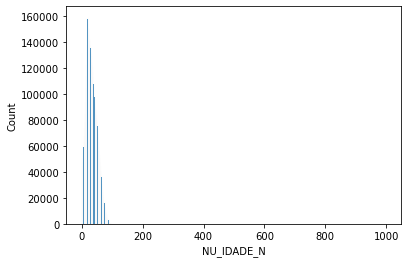

In [8]:
sns.histplot(df.NU_IDADE_N);

Hay algunos _outliers_, edades muy altas de más de 100 años, lo que no tiene sentido. Miremos cuántos datos descartamos considerando un corte en la edad máxima:

In [9]:
lenght=len(df)
for thr in [60,65,70,75,80]:
    print( len(df[df.NU_IDADE_N<thr] ) / lenght )

0.9095698177597704
0.942515174803217
0.9655608535379356
0.9807363994164463
0.9906853904513332


Si cortamos en 80 años, perdemos menos de 1% de los datos. Por lo tanto lo hacemos:

In [10]:
df=df[df.NU_IDADE_N<80]

Analicemos ahora la columna EVOLUCAO.

In [11]:
df.EVOLUCAO.value_counts(normalize=True)

1    0.906731
9    0.092871
3    0.000294
2    0.000088
4    0.000015
Name: EVOLUCAO, dtype: float64

Vemos que no contiene muchos datos relevantes, considerando que la gran mayoría de los pacientes mejoró (1) o no hay información de su estado (9). Los códigos 2/3/4, que indican muerte por distintas razones, son menos de 0.03% de los datos. Además de lo comentado anteriormente, esta columna agrega información sobre el desnenlace final de la enfermedad y este es un dato del que por supuesto no disponemos al momento del primer análisis. Por esto descartamos esta feature.

In [12]:
df=df.drop(columns=['EVOLUCAO'])

Analizando la columna _target_, vemos que tenemos tres diagnósticos: dengue, chikunguña y "no concluyentes". El inconveniente que se presenta es que cuando analizamos en profundidad los datos asociados a cada diagnóstico nos encontramos con que tenemos poco mas de 100 registros con información útil para los casos de chikunguña. Si consideramos que contamos con mas de 2 millones de datos en total, nos resulta imposible realizar un análisis de tan pocos datos. Por este motivo tuvimos que optar por descartarlos y solo realizar un análisis de los datos de dengue.

In [13]:
df.CLASSI_FIN.value_counts()

Dengue                    4268955
Discarded/Inconclusive    2081592
Chikungunya                319284
Name: CLASSI_FIN, dtype: int64

_De los casi 320000 datos de Chikungunya, poco mas de 100 registros contiene información de utilidad_

In [14]:
print(len(df))
df=df[df.CLASSI_FIN != 'Chikungunya']
print(len(df))

6669831
6350547


Vamos a realizar entonces una classificación binaria, dengue SI/NO. Transformamos en 0/1 la columna _target_. 

In [15]:
df.CLASSI_FIN.replace({'Dengue':1,'Discarded/Inconclusive':0},inplace=True)

In [16]:
df.CLASSI_FIN.value_counts()

1    4268955
0    2081592
Name: CLASSI_FIN, dtype: int64

Consideremos ahora las columnas con síntoma "fiebre" y raza y sexo del paciente. Hay muchos datos con el valor "9" que indica "Ignored / Sin información", es decir que son datos que no nos aportan información de importancia y por lo tanto los quitamos de nuestro dataset.

In [17]:
print(df.shape)
df=df[df.FEBRE != 9]
df=df[df.CS_SEXO != 9]
df=df[df.CS_RACA != 9]
print(df.shape)

(6350547, 34)
(2292121, 34)


Todavía nos quedamos con mas de 2 millones de datos.

Observamos como queda nuestro dataset actual.

En el caso de la fecha de comienzo de síntomas, nos interesa agrupar los datos por meses para saber si existe alguna correlación entre la época del año y los casos de dengue notificados.

In [18]:
df['DT_SIN_PRI']

0          2018-05-06
1          2018-02-03
2          2018-01-05
3          2018-05-04
4          2018-04-02
              ...    
6191573    2016-04-11
6191582    2016-04-10
6191610    2016-02-29
6191626    2016-08-15
6191627    2016-01-05
Name: DT_SIN_PRI, Length: 2292121, dtype: object

In [19]:
# Convertimos la columna a tipo datetime
df['DT_SIN_PRI'] = pd.to_datetime(df['DT_SIN_PRI'],errors='coerce')

In [20]:
# Creamos la columna MES_NOT, con el mes en que empezaran los sintomas
df['MES_NOT'] = pd.DatetimeIndex(df['DT_SIN_PRI']).month
df['MES_NOT'].value_counts(dropna=False)

4.0     453501
3.0     436434
5.0     393223
2.0     325026
1.0     181044
6.0     171838
7.0      80560
12.0     68944
11.0     51158
8.0      48847
10.0     41815
9.0      39723
NaN          8
Name: MES_NOT, dtype: int64

In [21]:
df=df.dropna() # Quitamos los 8 registros con fechas en formato incorrecto

Consideramos ahora el municipio de residencia del paciente. El dengue puede ser más o menos incidente en grandes centros urbanos, o también en ciudades con condiciones sanitarias precarias o con bajo nivel socioeconómico. Como no es fácil encontrar dados sociales para cada município de Brasil, pero si es fácil encontrar números geográficos cuantitativos, como población y área, vamos crear una nueva _feature_ que contiene la densidad poblacional del municipio del paciente, que potencialmente puede indicar si hay más chances de que tenga dengue o no.

En nuestro dataset, los municípios son representados por su código IBGE correspondiente. La densidad poblacional de cada municipio fue obtenida del sítio web https://sidra.ibge.gov.br/tabela/1301. Además, como el código de cada municipio utilizado en esta página es del tipo IBGE-7, tuvimos que bajar un segundo dataset para obtener la relación entre los códigos IBGE / IBGE-7.

In [22]:
df_mun = pd.read_csv('Lista_Municípios_com_IBGE_Brasil_Versao_CSV.csv',low_memory=False,encoding='latin-1',sep=';')
df_pop = pd.read_csv('tabela_Dens.csv',low_memory=False,encoding='latin-1',header=None)
df_pop.columns=['IBGE7','Municipio','Densidad_Poblacional']

La idea es hacer un diccionario que relaciona los códigos IBGE-7 y IBGE, y un segundo diccionario que relaciona el código IBGE con la densidad poblacional. Después, mapeamos los dos diccionarios y creamos una nueva columna en nuestro dataset original llamada _Densidad_Mun_, o densidad poblacional del municipio del paciente.

In [23]:
ibge7_ibge=dict(zip(df_mun.IBGE7,df_mun.IBGE))
df_pop['IBGE']=df_pop.IBGE7.map(ibge7_ibge)

ibge_densidad=dict(zip(df_pop.IBGE,df_pop.Densidad_Poblacional))
df['Densidad_Mun']=df.ID_MN_RESI.map(ibge_densidad)

In [24]:
df.columns

Index(['DT_SIN_PRI', 'NU_IDADE_N', 'CS_SEXO', 'CS_GESTANT', 'CS_RACA',
       'ID_MN_RESI', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO',
       'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA',
       'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES',
       'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT',
       'AUTO_IMUNE', 'RESUL_SORO', 'RESUL_NS1', 'RESUL_VI_N', 'RESUL_PCR_',
       'HISTOPA_N', 'IMUNOH_N', 'CLASSI_FIN', 'MES_NOT', 'Densidad_Mun'],
      dtype='object')

En algunos casos no había relación entre IBGE/Densidad por lo que los descartamos

In [25]:
print(len(df))
df=df.dropna()
print(len(df))

2292113
2291869


Ploteamos un histograma con la densidad poblacional para los casos positivos/negativos de Dengue:

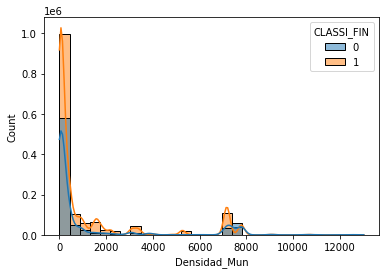

In [26]:
sns.histplot(data=df,x='Densidad_Mun',bins=30,hue='CLASSI_FIN',kde=True);

Vemos que gran parte de los municipios tienen una densidad poblacional muy baja y es difícil reconocer un patrón claro. Pero sí podemos ver que la tasa de positivos/negativos para el dengue no es uniforme cuando lo miramos en función de la densidad poblacional. Entonces vamos a crear categorías para dividir en grupos los municipios. Para saber cuantas categorás crear, hagamos un análisis rápido de porcentaje de casos positivos de dengue en función de la densidad poblacional normalizada para distintos q-quartiles.

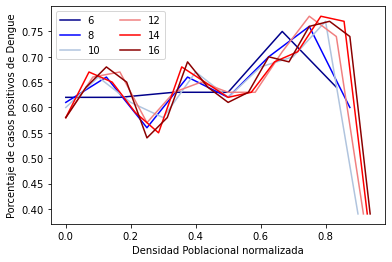

In [27]:
xq = []
for size_q in range(6,18): # De 6 a 18 quartiles
    mylabels=[]
    for i in range(1,size_q+1):
        mylabels.append( "q"+str(i) )
    df['Temp']=pd.qcut(df.Densidad_Mun, q=size_q,labels=mylabels)
    xq_i=[]
    for name in mylabels:
        v=df[df.Temp == name]
        a=v.CLASSI_FIN.value_counts(normalize=True)
        xq_i.append(np.round(a[1],2))
    xq.append(xq_i)
    
c=['darkblue','blue','lightsteelblue','lightcoral','red','darkred']
l=['6','8','10','12','14','16']
for max in range(6,18,2):
    x=np.arange(0,max)/max
    plt.plot(x,xq[max-6],color=c[int((max-6)/2)],label=l[int((max-6)/2)])
plt.xlabel('Densidad Poblacional normalizada')
plt.ylabel('Porcentaje de casos positivos de Dengue')
plt.legend(ncol=2);

Sabemos que considerando todo el dataset, la tasa de positivos para Dengue es 65%. La distribución en función de la densidad no es para nada uniforme, con tres picos bien marcados, principalmente en ciudades con una alta densidad poblacional. Además, vemos una convergencia de la curva a partir de 14 quartiles. Crearemos, por lo tanto, 15 grupos, de _q1_ hasta _q15_.

In [28]:
size_q=15
mylabels=[]
for i in range(1,size_q+1):
    mylabels.append( "q"+str(i) )
        
df.Densidad_Mun=pd.qcut(df.Densidad_Mun, q=size_q,labels=mylabels)

Ahora podemos eliminar las columnas originales con fechas y municipio y también la columna con datos temporales que habiamos creado.

In [30]:
df=df.drop(columns=['DT_SIN_PRI','ID_MN_RESI','Temp'])

In [31]:
df.head()

,NU_IDADE_N,CS_SEXO,CS_GESTANT,CS_RACA,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,...,AUTO_IMUNE,RESUL_SORO,RESUL_NS1,RESUL_VI_N,RESUL_PCR_,HISTOPA_N,IMUNOH_N,CLASSI_FIN,MES_NOT,Densidad_Mun
0,22.0,0,5,4,1,1,1,2,2,1,...,2,4,4,4,4,4,4,1,5.0,q4
1,35.0,1,6,4,1,2,1,2,1,1,...,2,4,4,4,4,4,4,1,2.0,q4
2,44.0,1,6,4,1,1,2,2,2,1,...,2,4,4,4,4,4,4,1,1.0,q4
3,3.0,1,6,1,1,2,1,2,2,2,...,2,4,4,4,4,4,4,0,5.0,q9
4,10.0,0,6,1,1,2,2,2,1,2,...,2,4,4,4,4,4,4,0,4.0,q9


Notamos que las columnas con resultados de laboratorio con testeos para analizar si la persona tiene Dengue o no son pocas en realidad. En la gran mayoría de los casos tenemos el código "4", que indica que no fue hecho el test. Miremos cuántos son los casos en que el resultado del testeo fue negativo o positivo:

In [32]:
testeos_lab = ['RESUL_SORO', 'RESUL_NS1', 'RESUL_VI_N','RESUL_PCR_', 'HISTOPA_N','IMUNOH_N']
for x in testeos_lab:
    print(x,df[df[x]==2].shape[0],df[df[x]==1].shape[0])

RESUL_SORO 37926 23027
RESUL_NS1 91550 16219
RESUL_VI_N 1767 113
RESUL_PCR_ 3657 514
HISTOPA_N 1014 287
IMUNOH_N 1253 187


Solamente 160000 testeos aproximadamente fueran realizados, en casi 2 millones de datos. La gran mayoría de los testeos de laboratório fueron del tipo _NS1_ o _SORO_, con las otras técnicas representando menos de 5% de los casos. Además, observemos cómo está relacionado el resultado del testeo con el diagnóstico.

In [33]:
print("Examen - Positivo - Negativo")
for x in testeos_lab:
    # De los resultados de lab. positivos (df[df[x]==1]), cuántos fueron clasificados como positivos (CLASSI_FIN == 1)
    V1 = (df[df[x]==1].CLASSI_FIN == 1).sum() 
    # De los resultados de lab. negativos (df[df[x]==2]), cuántos fueron clasificados como negativos (CLASSI_FIN == 0)
    V2 = (df[df[x]==2].CLASSI_FIN == 0).sum() 
      
    N1 = len(df[df[x]==1]) # Número de resultados positivos del testeo
    N2 = len(df[df[x]==2]) # Número de resultados negativos del testeo
        
    print(x,np.round(100*V1/N1,1),np.round(100*V2/N2,1))

Examen - Positivo - Negativo
RESUL_SORO 92.7 62.4
RESUL_NS1 91.8 64.0
RESUL_VI_N 89.4 38.3
RESUL_PCR_ 94.4 42.7
HISTOPA_N 89.2 51.7
IMUNOH_N 86.6 42.5


Por lo tanto, aún cuando el resultado del testeo fue positivo para el virus del Dengue, el diagnóstico final fue positivo en aproximadamente el 92% de los casos. De manera similar, cuando el resultado del testeo fue negativo, aproximadamente el 63% de los casos fueron finalmente clasificados como negativos. Es deciir, tenemos una divergencia entre los resultados de testeos de laboratorio y el diagnóstico final. En este trabajo, vamos considerar como "verdad" el diagnóstico final del médico, suponiendo que es el correcto y que los tests de laboratorio son solamente una _feature_ más. Hay que tener en cuenta por lo tanto que, si miramos solamente los testeos de laboratorio, tenemos una precisión en torno al 75%.

Vamos a categorizar la columna con los testeos:

In [34]:
for x in df[testeos_lab].columns:
    df[x]=df[x].replace({1:'Positivo',2:'Negativo',3:'Inconcl.',4:'Ausente'})

La columna con información sobre el período de gestación de las mujeres embarazadas, puede ser simplificada transformándola en una feature binaria: si la persona está embarazada o no.

In [35]:
df.CS_GESTANT.value_counts()

6    1302828
5     852739
9     111872
2       8047
3       6728
1       6251
4       3404
Name: CS_GESTANT, dtype: int64

In [36]:
df.CS_GESTANT=df.CS_GESTANT.replace({1:1,2:1,3:1,4:0,5:0,6:0,9:0})

In [37]:
df.CS_GESTANT.value_counts()

0    2270843
1      21026
Name: CS_GESTANT, dtype: int64

Tenemos las siguientes columnas:

In [38]:
df.columns

Index(['NU_IDADE_N', 'CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'FEBRE', 'MIALGIA',
       'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT',
       'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO',
       'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA',
       'ACIDO_PEPT', 'AUTO_IMUNE', 'RESUL_SORO', 'RESUL_NS1', 'RESUL_VI_N',
       'RESUL_PCR_', 'HISTOPA_N', 'IMUNOH_N', 'CLASSI_FIN', 'MES_NOT',
       'Densidad_Mun'],
      dtype='object')

Para los datos de síntomas, transformamos los "2" (sin síntoma) en "0", quedándonos con 0 y 1, en lugar de 1 y 2.

In [39]:
int_col=['FEBRE', 'MIALGIA','CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT',
       'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO','DIABETES',
        'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA','ACIDO_PEPT', 'AUTO_IMUNE']
for x in int_col:
    df[x]=df[x].replace({2:0})

In [40]:
df.shape

(2291869, 34)

In [41]:
df.head()

,NU_IDADE_N,CS_SEXO,CS_GESTANT,CS_RACA,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,...,AUTO_IMUNE,RESUL_SORO,RESUL_NS1,RESUL_VI_N,RESUL_PCR_,HISTOPA_N,IMUNOH_N,CLASSI_FIN,MES_NOT,Densidad_Mun
0,22.0,0,0,4,1,1,1,0,0,1,...,0,Ausente,Ausente,Ausente,Ausente,Ausente,Ausente,1,5.0,q4
1,35.0,1,0,4,1,0,1,0,1,1,...,0,Ausente,Ausente,Ausente,Ausente,Ausente,Ausente,1,2.0,q4
2,44.0,1,0,4,1,1,0,0,0,1,...,0,Ausente,Ausente,Ausente,Ausente,Ausente,Ausente,1,1.0,q4
3,3.0,1,0,1,1,0,1,0,0,0,...,0,Ausente,Ausente,Ausente,Ausente,Ausente,Ausente,0,5.0,q9
4,10.0,0,0,1,1,0,0,0,1,0,...,0,Ausente,Ausente,Ausente,Ausente,Ausente,Ausente,0,4.0,q9


Para la raza, la edad, mes de notificación, días con síntomas y testeos de laboratório, vamos usar la función "get_dummies" de Pandas. Primero, transformamos los códigos de la raza en objetos, siguiendo el diccionario provisto con la documentación del dataset:

In [42]:
df.CS_RACA=df.CS_RACA.replace({1:'White',2:'Black',3:'Yellow',4:'Brown',5:'Indigenous'})

Como la edad exacta no importa, pero sí importa si la persona es joven, adulta o adulta mayor, vamos definir categorías.

In [43]:
def tomap(x):
    if x < 18:
        return '0-18'
    elif x < 30:
        return '18-30'
    elif x < 50:
        return '30-50'
    else:
        return '50-80'

df.NU_IDADE_N=df.NU_IDADE_N.apply(tomap)

In [44]:
df.NU_IDADE_N.value_counts()

30-50    734880
18-30    607784
0-18     524308
50-80    424897
Name: NU_IDADE_N, dtype: int64

En el caso del mes de notificación, reemplazamos los valores numéricos por el mes y transformamos así en una variable categórcia.

In [45]:
df['MES_NOT']=df['MES_NOT'].replace({1:'enero',
                                     2:'febrero',
                                     3:'marzo',
                                     4:'abril',
                                     5:'mayo',
                                     6:'junio',
                                     7:'julio',
                                     8: 'agosto',
                                     9: 'septiembre',
                                     10: 'octubre',
                                     11: 'noviembre',
                                     12: 'diciembre'})

Finalmente tranformamos las columnas con más de 1 categoría en muchas columnas con solamente 2 categorías 0/1, usando "get_dummies".

In [46]:
add_dummies=pd.get_dummies(df[['NU_IDADE_N','CS_RACA','MES_NOT','RESUL_SORO','Densidad_Mun',
                               'RESUL_NS1', 'RESUL_VI_N', 'RESUL_PCR_','HISTOPA_N', 'IMUNOH_N']],drop_first=True)

In [47]:
df=pd.concat([df,add_dummies],axis=1)

In [48]:
# Sacamos las columnas originales
df.drop(columns=['NU_IDADE_N','CS_RACA','MES_NOT','Densidad_Mun','RESUL_SORO',
                 'RESUL_NS1', 'RESUL_VI_N', 'RESUL_PCR_','HISTOPA_N', 'IMUNOH_N'],inplace=True)

Nuestro dataset final contiene solamente datos categóricos, y se ve así:

In [49]:
df.head()

,CS_SEXO,CS_GESTANT,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,...,RESUL_VI_N_Positivo,RESUL_PCR__Inconcl.,RESUL_PCR__Negativo,RESUL_PCR__Positivo,HISTOPA_N_Inconcl.,HISTOPA_N_Negativo,HISTOPA_N_Positivo,IMUNOH_N_Inconcl.,IMUNOH_N_Negativo,IMUNOH_N_Positivo
0,0,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Además, la columna _target_ tiene 65% de casos positivos de Dengue, y 35% de negativo o inconclusivo.

In [50]:
np.round(df.CLASSI_FIN.value_counts(normalize=True),2)

1    0.65
0    0.35
Name: CLASSI_FIN, dtype: float64

Como todas las columnas son del tipo categóricas, podemos reducir mucho el tamaño en memoria del dataset:

In [51]:
for x in df.columns:
    df[x]=df[x].astype('uint8')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2291869 entries, 0 to 6191627
Data columns (total 74 columns):
 #   Column               Dtype
---  ------               -----
 0   CS_SEXO              uint8
 1   CS_GESTANT           uint8
 2   FEBRE                uint8
 3   MIALGIA              uint8
 4   CEFALEIA             uint8
 5   EXANTEMA             uint8
 6   VOMITO               uint8
 7   NAUSEA               uint8
 8   DOR_COSTAS           uint8
 9   CONJUNTVIT           uint8
 10  ARTRITE              uint8
 11  ARTRALGIA            uint8
 12  PETEQUIA_N           uint8
 13  LEUCOPENIA           uint8
 14  LACO                 uint8
 15  DOR_RETRO            uint8
 16  DIABETES             uint8
 17  HEMATOLOG            uint8
 18  HEPATOPAT            uint8
 19  RENAL                uint8
 20  HIPERTENSA           uint8
 21  ACIDO_PEPT           uint8
 22  AUTO_IMUNE           uint8
 23  CLASSI_FIN           uint8
 24  NU_IDADE_N_18-30     uint8
 25  NU_IDADE_N_30-50  

### Análisis de algunas _features_ relevantes de síntomas

Con nuestro dataset limpio, miremos la relación de algunas _features_ con la columna target. Como tenemos más de 50 columnas, mostramos solo las más correlacionadas.

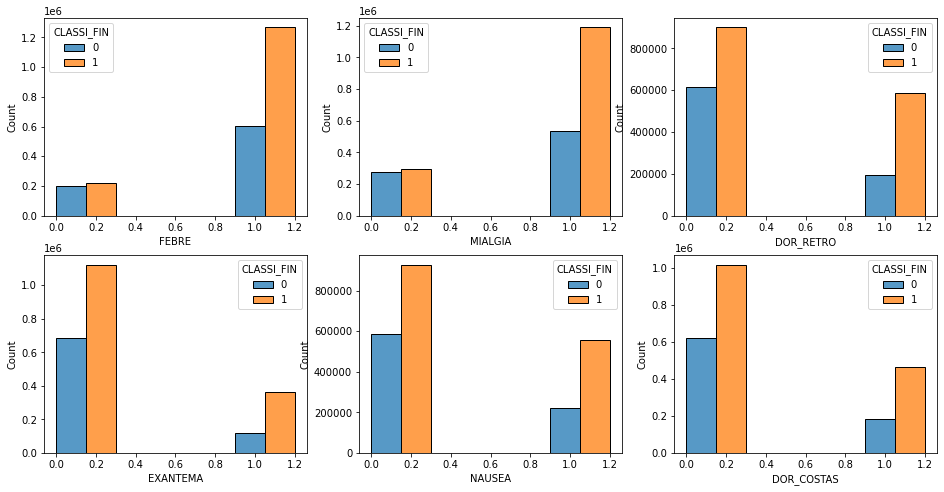

In [53]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
sns.histplot(data = df, x = 'FEBRE', hue = 'CLASSI_FIN', multiple = 'dodge', binwidth = 0.3, ax=axs[0,0]);
sns.histplot(data = df, x = 'MIALGIA', hue = 'CLASSI_FIN', multiple = 'dodge', binwidth = 0.3, ax=axs[0,1]);
sns.histplot(data = df, x = 'DOR_RETRO', hue = 'CLASSI_FIN', multiple = 'dodge', binwidth = 0.3, ax=axs[0,2]);
sns.histplot(data = df, x = 'EXANTEMA', hue = 'CLASSI_FIN', multiple = 'dodge', binwidth = 0.3, ax=axs[1,0]);
sns.histplot(data = df, x = 'NAUSEA', hue = 'CLASSI_FIN', multiple = 'dodge', binwidth = 0.3, ax=axs[1,1]);
sns.histplot(data = df, x = 'DOR_COSTAS', hue = 'CLASSI_FIN', multiple = 'dodge', binwidth = 0.3, ax=axs[1,2]);

Se puede ver que cuando la persona presenta algunos de los síntomas (por ejemplo, fiebre, mialgia y dolor detrás de los ojos), la proporción entre quienes tienen dengue y quienes no tienen es más alta que cuando no presentan los síntomas.

# Modelando

Primero, consideramos como métrica general el área bajo la curva ROC. Para esto, vamos a definir una función simple que la evalúa en el dataset de entrenamiento y de validación o testeo.

In [54]:
def evalua_auc(texto,modelo,xt,yt,xv,yv):
    yt_pred = modelo.predict_proba(xt)
    yv_pred = modelo.predict_proba(xv)
    ft,tt,_ = roc_curve(yt, yt_pred[:,1])
    fv,tv,_ = roc_curve(yv, yv_pred[:,1])
    print(texto,np.round(auc(ft, tt),3),np.round(auc(fv, tv),3))

Separando la columna 'target' de las 'features'.

In [206]:
X=df.drop(columns=['CLASSI_FIN'])
y=df.CLASSI_FIN

Dividimos en aprox. 70/10/20 para entrenamiento/validación/testeo, respectivamente.

In [207]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=55,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6666667, random_state=55,stratify=y_temp)
X_train.shape,X_val.shape,X_test.shape

((1604308, 73), (229186, 73), (458375, 73))

Considerando ahora diferentes grupos de _features_.

## Caso 1: Analizamos solo los síntomas

Un paciente llega al hospital, se saben sus síntomas, su edad, raza, si hay embarazo, pero nada más. No sabemos, por ejemplo, mucho de su historial clínico, de donde viene y en que més comenzó a sentir los síntomas. Solo con esta información y, sin realizar testeos de laboratorio, vamos a determinar con qué porcentaje de certeza podemos decir si tiene Dengue o no?

Filtrando las columnas de interés:

In [57]:
columns1 = ['CS_SEXO', 'CS_GESTANT', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA','VOMITO', 'NAUSEA', 
            'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA','PETEQUIA_N', 'LACO', 'DOR_RETRO', 
            'NU_IDADE_N_18-30','NU_IDADE_N_30-50', 'NU_IDADE_N_50-80',
            'CS_RACA_Brown','CS_RACA_Indigenous', 'CS_RACA_White', 'CS_RACA_Yellow']

X_train1 = X_train[columns1]
X_val1 = X_val[columns1]
X_test1 = X_test[columns1]

Controlamos que la proporción de casos positivos/negativos para Dengue sean iguales en todos los datasets

In [58]:
print(np.round(y_train.value_counts(normalize=True),2));
print(np.round(y_val.value_counts(normalize=True),2));
print(np.round(y_test.value_counts(normalize=True),2));

1    0.65
0    0.35
Name: CLASSI_FIN, dtype: float64
1    0.65
0    0.35
Name: CLASSI_FIN, dtype: float64
1    0.65
0    0.35
Name: CLASSI_FIN, dtype: float64


En general, las features con las cuales estamos trabajando casi no presentan relación entre ellas. De hecho, el dataset consiste en features muy poco correlacionadas como síntomas, raza, sexo, fecha, etc. Debido a que las columnas son casi independentes, modelar con Naive Bayes podría potencialmente tener una _performance_ muy buena con un bajo costo computacional. 

In [59]:
cat_nb = CategoricalNB()

In [60]:
cat_nb.fit(X_train1,y_train)

CategoricalNB()

In [61]:
evalua_auc("AUC / Naive-Bayes",cat_nb,X_train1,y_train,X_val1,y_val)

AUC / Naive-Bayes 0.654 0.653


Entonces tomamos como baseline el valor obtenido, 0.653 para el AUC. Ahora observemos qué sucede aplicando un modelo de decision tree simple.

In [62]:
print("Depth AUC(train) AUC(val)")
for md in range(2,20):
    dec_tree = DecisionTreeClassifier(max_depth=md)
    dec_tree.fit(X_train1,y_train)
    evalua_auc(md,dec_tree,X_train1,y_train,X_val1,y_val)

Depth AUC(train) AUC(val)
2 0.612 0.611
3 0.627 0.625
4 0.643 0.641
5 0.652 0.651
6 0.657 0.656
7 0.663 0.661
8 0.667 0.664
9 0.67 0.666
10 0.672 0.668
11 0.674 0.669
12 0.677 0.669
13 0.68 0.668
14 0.683 0.666
15 0.687 0.664
16 0.691 0.662
17 0.695 0.661
18 0.698 0.659
19 0.701 0.658


2 puntos mejor que Naive-Bayes. Para árboles con una profundidad de 12 o más, ya notamos que hay sobreajuste en el set de entrenamiento, esto es esperable en árboles de decisión simples. Además, observamos que incluso los árboles más cortos ya tienen una _performance_ razonable, lo que indica probablemente que hay unas pocas _features_ mucho más importantes que las otras. Para entender cuáles son, miremos cómo se ve un árbol de decisión corto, con profundidad 3:

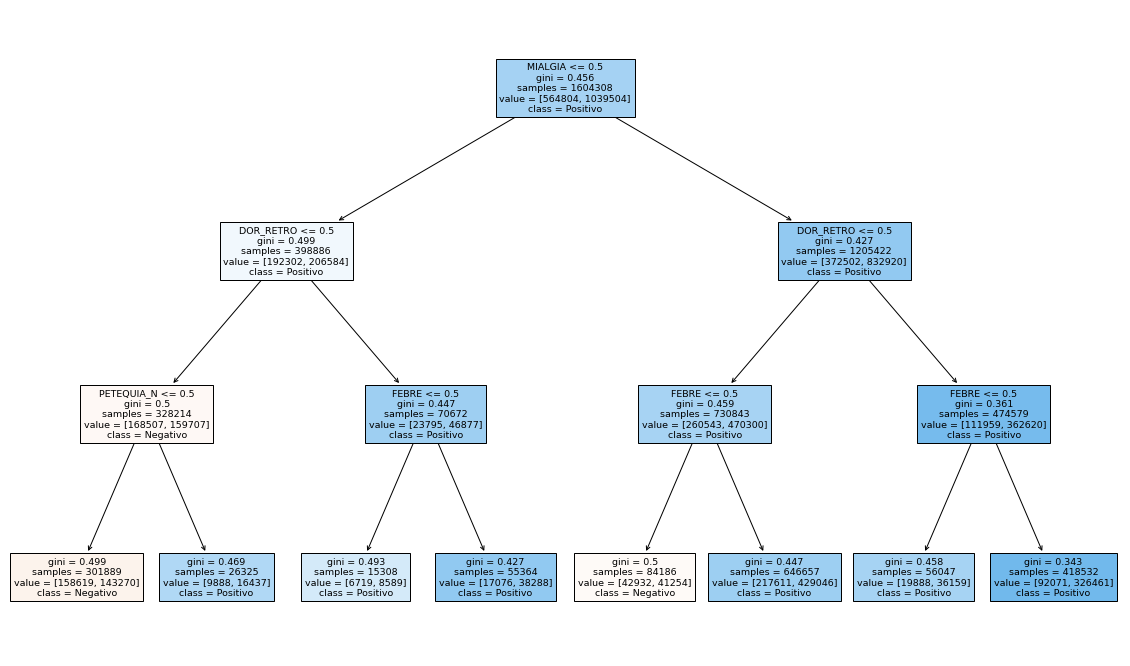

In [63]:
dec_tree = DecisionTreeClassifier(max_depth=3).fit(X_train1,y_train)
plt.figure(figsize=(20,12))
tree.plot_tree(dec_tree,feature_names=X_train1.columns,class_names=["Negativo","Positivo"],filled=True);

Vemos que las columnas más relevantes son: dolor detrás de los ojos ("DOR_RETRO", o "Retroorbital pain" del inglés), mialgia (dolor en los músculos), fiebre, petequia_N (relacionado con erupciones cutáneas en la piel).

Abandonamos un poco la intepretación y consideramos ahora los modelos más performantes, Random Forest y XGBoost. Comenzamos con la mayoría de los parámetros en _default_, excepto la produndidad de los árboles que ya vimos que pueden potencialmente causar sobreajuste cuando se los deja avanzar demasiado en profundidad.

In [64]:
rf = RandomForestClassifier(n_jobs=-1,max_depth=12)
rf.fit(X_train1,y_train)
evalua_auc("Random-Forest: ",rf,X_train1,y_train,X_val1,y_val)

Random-Forest:  0.678 0.671


Vemos que ganamos 1 punto más. Averiguamos ahora la _performance_ de XGBoost con parámetros _default_:

In [65]:
import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')

In [66]:
xgb = XGBClassifier(n_jobs=-1,use_label_encoder=False,eval_metric='logloss')
xgb.fit(X_train1,y_train)
evalua_auc("XGBoost: ",xgb,X_train1,y_train,X_val1,y_val)

XGBoost:  0.676 0.671


Para el _set_ de validación obtuvimos una _performance_ similar. Claro que una comparación justa entre los 2 métodos debería considerar los hiperparámetros óptimos de cada caso. El caso ideal sería hacer un _grid-search_ tanto para _Random Forest_ como para XGBoost, pero debido a limitaciones computacionales, haremos la búsqueda de hiperparámetros óptimos solamente para XGBoost.

In [67]:
cv = StratifiedKFold(n_splits=4, random_state=55, shuffle=True)

params = {  
    'max_depth': [10,12], 
    'n_estimators': [100,125], 
    'learning_rate': [0.1,0.15],
}

xgb = XGBClassifier(n_jobs=-1,use_label_encoder=False,eval_metric='logloss')
xgb_cv = GridSearchCV(xgb, param_grid=params, cv=cv, n_jobs=-1,scoring='roc_auc')
xgb_cv.fit(X_train1,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=55, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_ch...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                            

In [68]:
xgb_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}

In [69]:
evalua_auc("Grid-Search XGB: ",xgb_cv,X_train1,y_train,X_val1,y_val)

Grid-Search XGB:  0.683 0.671


Mejoramos menos de 1 punto con el Grid-Search. Veamos como fue la _performance_ para cada hiperparámetro elegido:

In [69]:
results=pd.DataFrame(xgb_cv.cv_results_)
results.mean_test_score.describe()

count    4.000000
mean     0.670112
std      0.001549
min      0.668302
25%      0.669136
50%      0.670201
75%      0.671178
max      0.671743
Name: mean_test_score, dtype: float64

In [70]:
results[['params','mean_test_score','std_test_score']]

,params,mean_test_score,std_test_score
0,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.671743,0.000762
1,"{'learning_rate': 0.1, 'max_depth': 12, 'n_est...",0.669413,0.000760
2,"{'learning_rate': 0.15, 'max_depth': 10, 'n_es...",0.670989,0.000771
3,"{'learning_rate': 0.15, 'max_depth': 12, 'n_es...",0.668302,0.000699


En general, vemos que el valor cambia poco para distintos hiperparámetros. Se observa también que el desvio entre diferentes _splits_ es muy bajo. Debido a que las búsquedas por _GridSearch_ son computacionalmente caras y no mejoran de manera sustancial el resultado final, no vamos a hacer una búsqueda mucho más detallada de los mejores hiperparámetros. Nos quedamos con 100 estimadores, pronfudidad igual a 10 y tasa de aprendizaje igual a 0.1.

Vamos ahora a considerar la performance final del modelo en los datos de testeo.

In [71]:
print(classification_report(y_val,xgb_cv.predict(X_val1)))

              precision    recall  f1-score   support

           0       0.59      0.30      0.39     80686
           1       0.70      0.89      0.78    148500

    accuracy                           0.68    229186
   macro avg       0.64      0.59      0.59    229186
weighted avg       0.66      0.68      0.65    229186



In [72]:
print(confusion_matrix(y_test,xgb_cv.predict(X_test1)))

[[ 48025 113348]
 [ 33021 263981]]


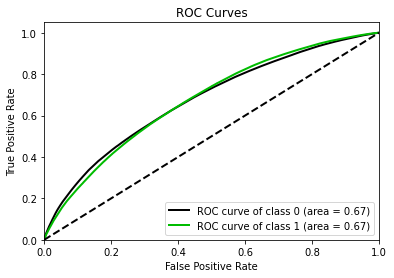

In [73]:
plot_roc(y_test, xgb_cv.predict_proba(X_test1), plot_micro = False, plot_macro= False);

In [74]:
probab = xgb_cv.predict_proba(X_test1)[:,1]
pd.Series(probab).describe()

count    458375.000000
mean          0.647985
std           0.143698
min           0.104769
25%           0.564917
50%           0.662163
75%           0.754870
max           0.989761
dtype: float64

Vemos que nuestro _recall_ es de 89% para detectar los positivos para dengue, pero predecimos incorrectamente casi 70% los casos negativos. 

Calculemos la área sobre la curva AUC para el _set_ de testeo:

In [75]:
y_pred = xgb_cv.predict_proba(X_test1)
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_pred[:,1])
print('AUC=', auc(fpr_log, tpr_log))

AUC= 0.6737065195844479


Tengamos como referencia este valor de 0.67 para la AUC y analicemos la importancia de las _features_.

In [76]:
xgb = XGBClassifier(n_jobs=-1,use_label_encoder=False,eval_metric='logloss',
                   max_depth=10,n_estimators=100,learning_rate=0.1)
xgb.fit(X_train1,y_train)
feat = pd.DataFrame(xgb.feature_importances_,index=X_train1.columns,columns=['Feature_Importance'])
feat_imp1 = feat.sort_values(by='Feature_Importance',ascending=False)

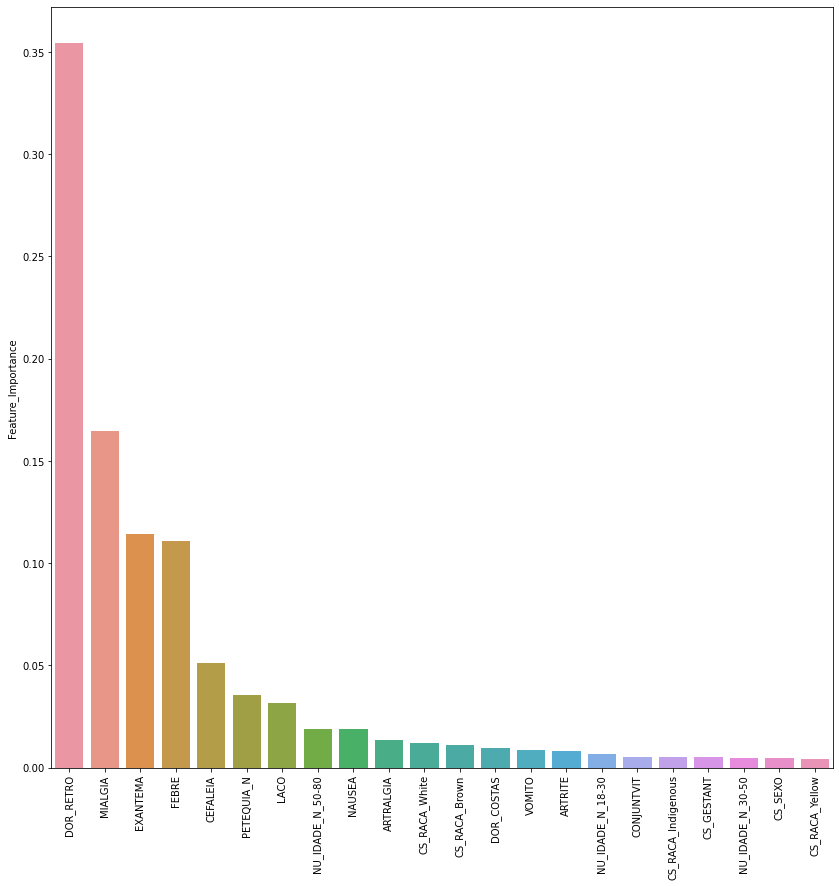

In [77]:
plt.figure(figsize=(14,14))
sns.barplot(data=feat_imp1,x=feat_imp1.index,y='Feature_Importance')
plt.xticks(rotation=90);

In [78]:
perm_importance = permutation_importance(xgb, X_test1, y_test)
feat_imp2 = pd.DataFrame(perm_importance.importances_mean,index=X_train1.columns,columns=['Feature_Importance'])
feat_imp2 = feat_imp2.sort_values(by='Feature_Importance',ascending=False)

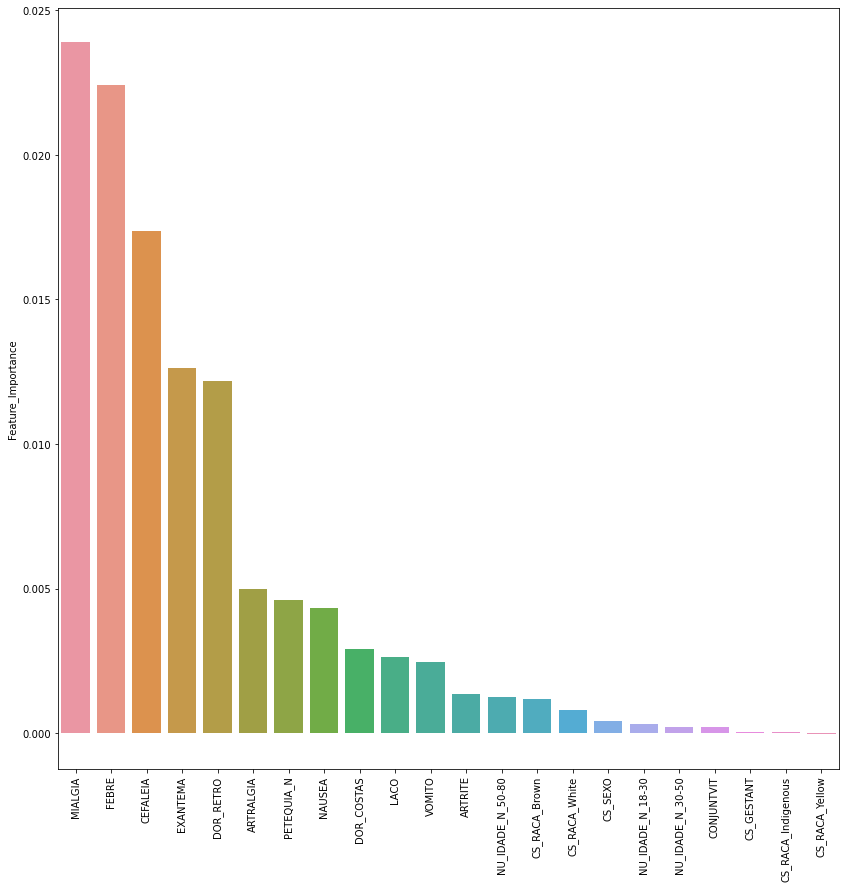

In [79]:
plt.figure(figsize=(14,14))
sns.barplot(data=feat_imp2,x=feat_imp2.index,y='Feature_Importance')
plt.xticks(rotation=90);

Vemos que las _features_ más importantes son síntomas, especialmente el dolor detrás de los ojos, dolor muscular, fiebre y dolor de cabeza. Por otro lado, la _feature_ "conjuntivitis" parece no aportar nada a las predicciones. La raza, el embarazo y el sexo son poco significativos. La edad también es poco relevante, excepto si el paciente se encuentra en el rango de 50-80. En este último caso, la evidencia parece demostrar que el paciente sufre un poco mas los síntmas de Dengue siendo necesario acudir al hospital.

## Caso 2: Síntomas, sumado a enfermedades preexistentes

Considereamos ahora que disponemos del historial clínico del paciente, por ejemplo, si tiene diabetes, es hipertenso, etc. Haremos solamente un XGBoost similar al que fue optimizado anteriormente.

In [80]:
doenzas_pre = ['DIABETES','HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT','AUTO_IMUNE']
columns2 = columns1 + doenzas_pre 

X_train2 = X_train[columns2]
X_val2 = X_val[columns2]
X_test2 = X_test[columns2]

In [81]:
xgb = XGBClassifier(n_jobs=-1,use_label_encoder=False,eval_metric='logloss',
                   max_depth=10,n_estimators=100,learning_rate=0.1)
xgb.fit(X_train2,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [82]:
evalua_auc("XGB: ",xgb,X_train2,y_train,X_test2,y_test)

XGB:  0.685 0.674


In [83]:
y_pred = xgb.predict(X_test2)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.59      0.30      0.39    161373
           1       0.70      0.89      0.78    297002

    accuracy                           0.68    458375
   macro avg       0.65      0.59      0.59    458375
weighted avg       0.66      0.68      0.65    458375



Por un lado, no observamos una mejora significativa en la performance del modelo, pero por otro lado, el resultado era de esperarse debido a que no contamos con una gran cantidad de datos de pacientes con enfermedades preexistentes.

In [84]:
for x in doenzas_pre:
    print(x,100*len(df[df[x]==1])/len(df))  # Porcentaje de casos analizados discriminados por enfermedidades preexistentes

DIABETES 2.2761335835512413
HEMATOLOG 0.4379395157402103
HEPATOPAT 0.4578795733962107
RENAL 0.3779884452383622
HIPERTENSA 5.659485773401534
ACIDO_PEPT 0.49693067099384824
AUTO_IMUNE 0.4013754712856625


De acuerdo al análisis anterior, vemos que estas enfermedades están presentes en el 0.4 al 5.7% de la población dependiendo del caso y era poco probable que aporten buena señal al modelo.

## Caso 3: Agregando el més del contagio

Considerando ahora el mes en que el paciente empezó a sentir los sintomas.

In [85]:
columns3 = columns2 + ['MES_NOT_agosto','MES_NOT_diciembre', 'MES_NOT_enero', 'MES_NOT_febrero',
                       'MES_NOT_julio', 'MES_NOT_junio', 'MES_NOT_marzo', 'MES_NOT_mayo',
                       'MES_NOT_noviembre', 'MES_NOT_octubre', 'MES_NOT_septiembre']

X_train3 = X_train[columns3]
X_val3 = X_val[columns3]
X_test3 = X_test[columns3]

In [86]:
xgb = XGBClassifier(n_jobs=-1,use_label_encoder=False,eval_metric='logloss',
                   max_depth=10,n_estimators=100,learning_rate=0.1)
xgb.fit(X_train3,y_train)
evalua_auc("XGB: ",xgb,X_train3,y_train,X_test3,y_test)

XGB:  0.704 0.693


In [87]:
print(classification_report(y_test,xgb.predict(X_test3)))

              precision    recall  f1-score   support

           0       0.61      0.32      0.42    161373
           1       0.71      0.89      0.79    297002

    accuracy                           0.69    458375
   macro avg       0.66      0.61      0.60    458375
weighted avg       0.67      0.69      0.66    458375



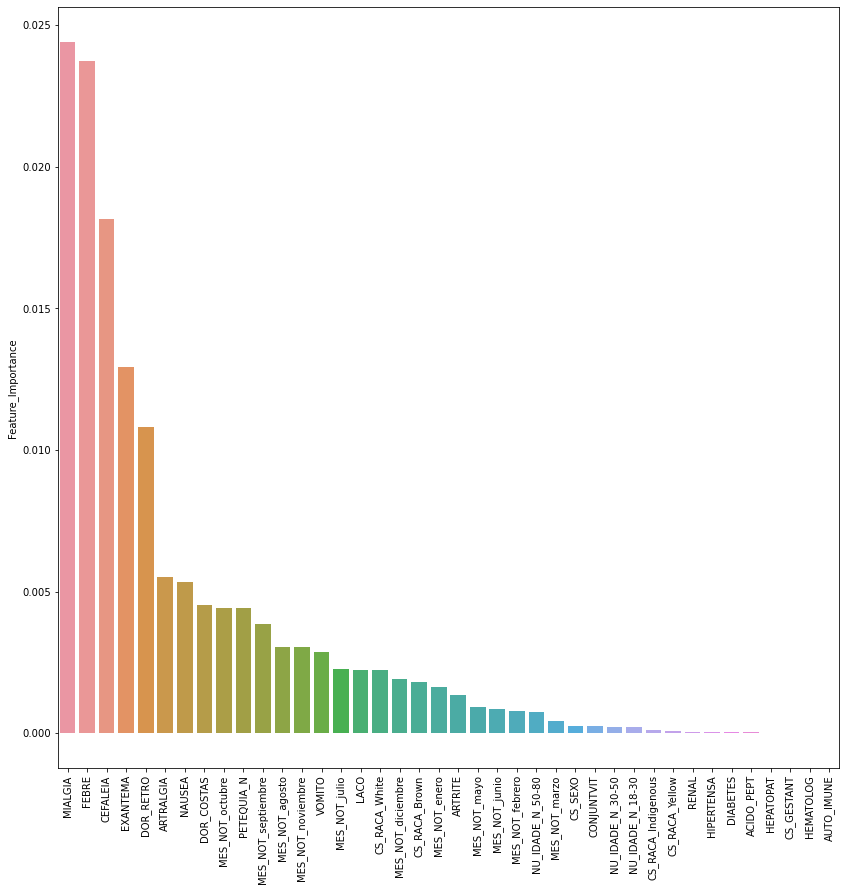

In [88]:
perm_importance = permutation_importance(xgb, X_test3, y_test)
feat_imp3 = pd.DataFrame(perm_importance.importances_mean,index=X_train3.columns,columns=['Feature_Importance'])
feat_imp3 = feat_imp3.sort_values(by='Feature_Importance',ascending=False)
plt.figure(figsize=(14,14))
sns.barplot(data=feat_imp3,x=feat_imp3.index,y='Feature_Importance')
plt.xticks(rotation=90);

Vemos una mejora de 2% en el recall de casos negativos y 1% en la accuracy media. Además, vemos que las nuevas _features_ tienen una importancia considerable. Esta mejora sucede principalmente en los meses de julio a noviembre cuando se observan menos casos de dengue, lo que explica la mejora en el precisión.

# Caso 4: Teniendo en cuenta el municipio de procedencia

Vamos a agregar ahora la información del municipio de origen del paciente. 

In [208]:
columns4 = columns3 + ['Densidad_Mun_q2','Densidad_Mun_q3','Densidad_Mun_q4','Densidad_Mun_q5',
                       'Densidad_Mun_q6','Densidad_Mun_q7','Densidad_Mun_q8','Densidad_Mun_q9',
                       'Densidad_Mun_q10','Densidad_Mun_q11','Densidad_Mun_q12','Densidad_Mun_q13',
                       'Densidad_Mun_q14','Densidad_Mun_q15']

X_train4 = X_train[columns4]
X_val4 = X_val[columns4]
X_test4 = X_test[columns4]

Como adicionamos muchas columnas, vamos a hacer un nuevo _grid-search_ para ver si los hiperparámetros óptimos siguen siendo los mismos.

In [ ]:
cv = StratifiedKFold(n_splits=4, random_state=55, shuffle=True)

params = {  
    'max_depth': [8,10],
    'n_estimators': [100,125], 
    'learning_rate': [0.1, 0.15,0.02], 
}

xgb = XGBClassifier(n_jobs=-1,use_label_encoder=False,eval_metric='logloss')
xgb_cv = GridSearchCV(xgb, param_grid=params, cv=cv, n_jobs=-1,scoring='roc_auc')
xgb_cv.fit(X_train4,y_train)

In [132]:
xgb_cv.best_params_
results=pd.DataFrame(xgb_cv.cv_results_)
results.mean_test_score.describe()
results[['params','mean_test_score','std_test_score']]

,params,mean_test_score,std_test_score
0,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.743858,0.000658
1,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.745669,0.000650
2,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.748491,0.000560
3,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.749772,0.000571
4,"{'learning_rate': 0.1, 'max_depth': 12, 'n_est...",0.750720,0.000595
5,"{'learning_rate': 0.1, 'max_depth': 12, 'n_est...",0.751286,0.000628
6,"{'learning_rate': 0.15, 'max_depth': 8, 'n_est...",0.746915,0.000492
7,"{'learning_rate': 0.15, 'max_depth': 8, 'n_est...",0.748211,0.000491
8,"{'learning_rate': 0.15, 'max_depth': 10, 'n_es...",0.750301,0.000594
9,"{'learning_rate': 0.15, 'max_depth': 10, 'n_es...",0.750831,0.000635


Vemos una gran mejora cuando consideramos el municipio de origen del paciente. Con respecto a los mejores hiperparametros, podemos observar que son muy similares a los que teníamos anteriormente, excepto cuando la _learning_rate_ asume un valore demasiado pequeño.

Probemos la _performance_ en el dataset de testeo.

In [91]:
xgb = XGBClassifier(n_jobs=-1,use_label_encoder=False,eval_metric='logloss',
                   max_depth=10,n_estimators=100,learning_rate=0.15)
xgb.fit(X_train4,y_train)
evalua_auc("XGB: ",xgb,X_train4,y_train,X_test4,y_test)

XGB:  0.766 0.751


In [92]:
print(classification_report(y_test,xgb.predict(X_test4)))

              precision    recall  f1-score   support

           0       0.66      0.43      0.52    161373
           1       0.74      0.88      0.80    297002

    accuracy                           0.72    458375
   macro avg       0.70      0.65      0.66    458375
weighted avg       0.71      0.72      0.70    458375



Una mejora de 5 puntos en el AUC. Vemos que la precisión mejoró bastante. Para los casos negativos tuvimos una mejora de 11 puntos (32% a 43%) mientras el recall para los casos positivos se mantuvo en casi 90%.

Veamos la importancia de las features.

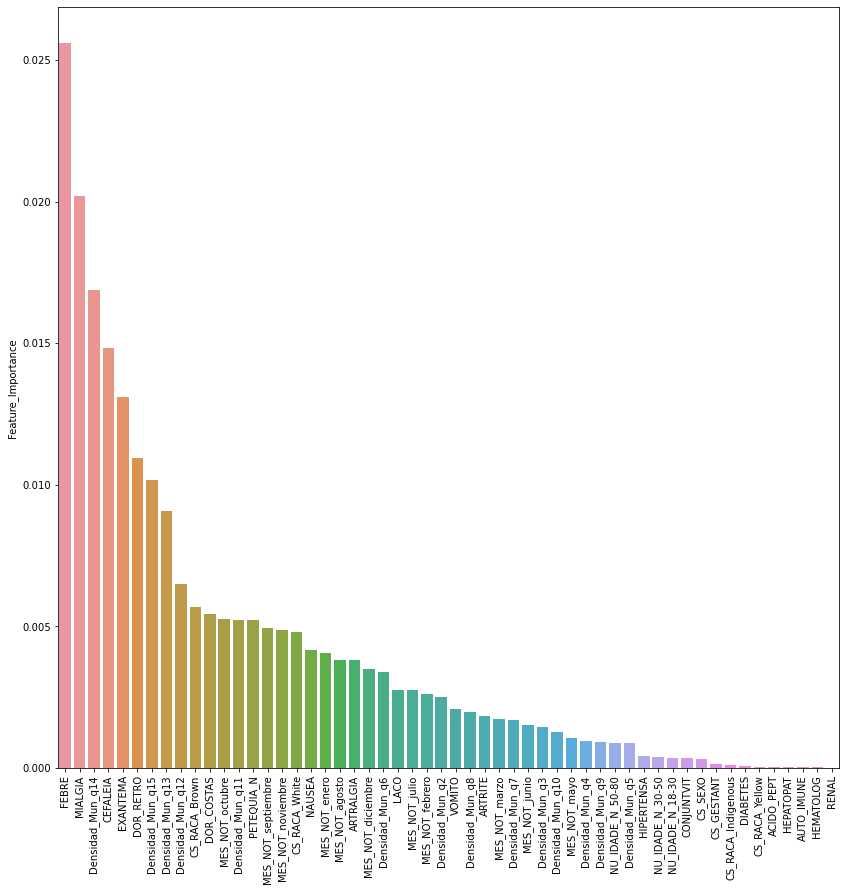

In [93]:
perm_importance = permutation_importance(xgb, X_test4, y_test)
feat_imp4 = pd.DataFrame(perm_importance.importances_mean,index=X_train4.columns,columns=['Feature_Importance'])
feat_imp4 = feat_imp4.sort_values(by='Feature_Importance',ascending=False)
plt.figure(figsize=(14,14))
sns.barplot(data=feat_imp4,x=feat_imp4.index,y='Feature_Importance')
plt.xticks(rotation=90);

Observamos en este caso una distribución mas compleja, donde los síntomas, el mes de contagio y la densidad poblacional del municipio de procedencia sob preponderantes

Por curiosidad, veamos como es un _decision tree_ simple de profundidad 3:

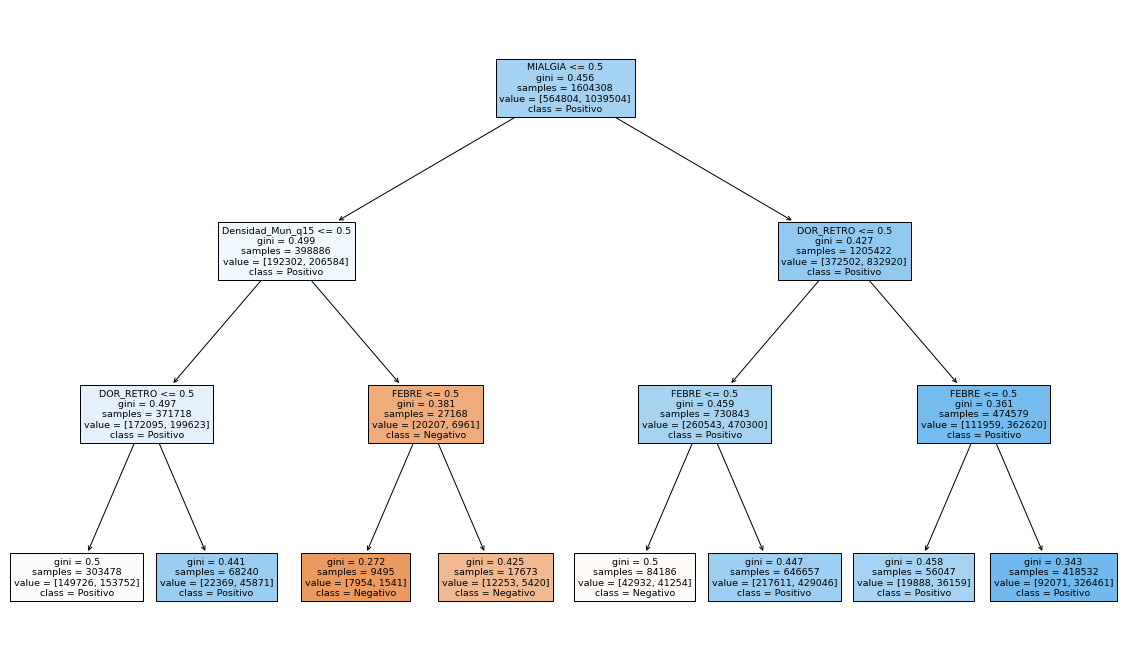

In [94]:
dec_tree = DecisionTreeClassifier(max_depth=3).fit(X_train4,y_train)
plt.figure(figsize=(20,12))
tree.plot_tree(dec_tree,feature_names=X_train4.columns,class_names=["Negativo","Positivo"],filled=True);

Vemos que es de mucha importancia conocer el municipio de precedencia del paciente, siendo particularmente importante saber si este municipio pertenece al grupo de mayor densidad poblacional. Una posible explicación es que en estos casos las personas viven mas próximas entre sí, posibilitando que un mismo mosquito infectado pique a varias de ellas.

# Caso 5: Agregando resultados de laboratorio

Vamos a considerar ahora los casos donde ya fueron realizados los análisis de laboratorio para determinar el diagnóstico, o sea, consideremos todas las _features_ trabajadas hasta ahora. Esto servirá como referencia de la precisión máxima que lograríamos obtener con las _features_ desarolladas hasta este punto del trabajo.

In [95]:
# XGBoost
xgb = XGBClassifier(n_jobs=-1,use_label_encoder=False,eval_metric='logloss',
                    learning_rate=0.15,max_depth=10,n_estimators=100)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [96]:
evalua_auc("XGB - Grid-Search",xgb,X_train,y_train,X_test,y_test)
print(classification_report(y_test,xgb.predict(X_test)))

XGB - Grid-Search 0.779 0.768
              precision    recall  f1-score   support

           0       0.67      0.45      0.54    161373
           1       0.75      0.88      0.81    297002

    accuracy                           0.73    458375
   macro avg       0.71      0.67      0.68    458375
weighted avg       0.72      0.73      0.71    458375



De lo observado anteriormente, 73% de _accuracy_ media y un AUC de 0.77 es el máximo de precisión que tenemos con las _features_ que consideramos hasta ahora. Es importante notar que, debido a que, en general, fueron realizados pocos testeos de laboratório (aproximadamente 160000 en un dataset de 2 millones de datos), no hay una mejora considerable en la precisión del modelo. Si hubiéramos usado solamente los datos que tienen algún tipo de testeo de laboratorio, la precisión media final seria en torno al 80% (este análisis fue realizado, pero no lo mostramos en esta notebook). Si bien es un valor considerablemente mejor, todavía nos encontramos lejos de un 95-100%, lo que es típico de la precisión de resultados de laboratório tradicionales.

Todo esto confirma que el diagnóstico de dengue es complejo aún cuando utilizamos múltiples herramientas distintas.

Las _features_ más importantes son:

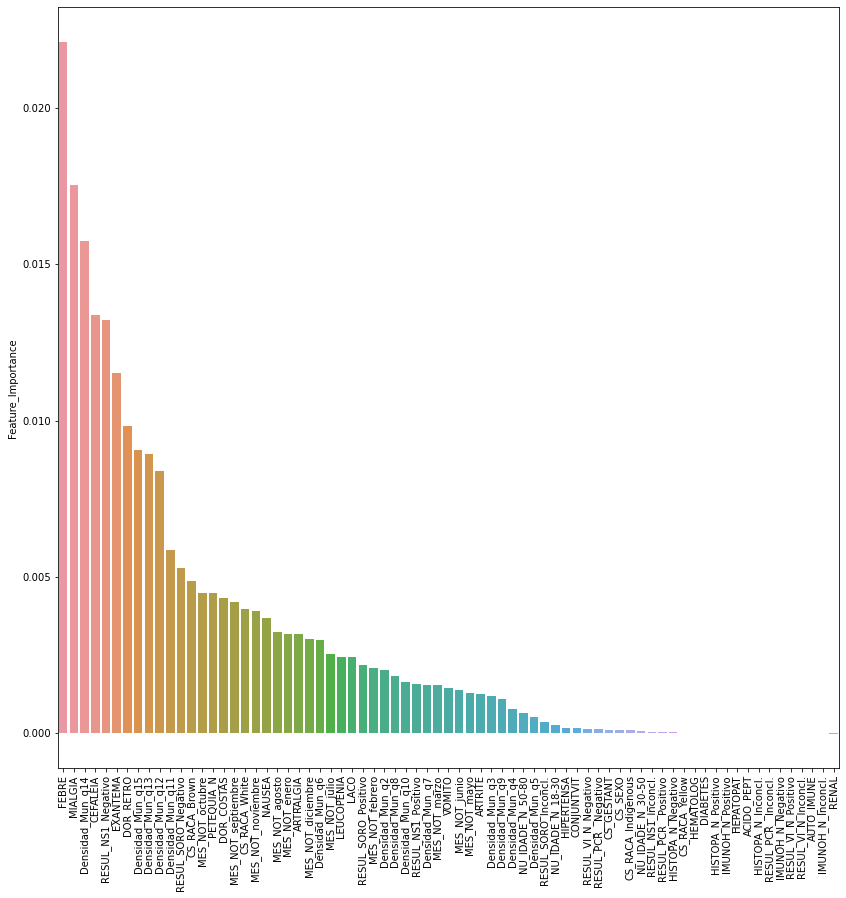

In [97]:
perm_importance = permutation_importance(xgb, X_test, y_test)
feat_imp = pd.DataFrame(perm_importance.importances_mean,index=X_train.columns,columns=['Feature_Importance'])
feat_imp = feat_imp.sort_values(by='Feature_Importance',ascending=False)
plt.figure(figsize=(14,14))
sns.barplot(data=feat_imp,x=feat_imp.index,y='Feature_Importance')
plt.xticks(rotation=90);

Vemos que los resultados de laboratório, SORO y NS1 (los 2 más utilizados) son muy importantes. Pero también vemos que los síntomas y otras _features_ discutidas previamente tienen igual o mayor importancia. Esto demuenstra el rol secundario de los testeos de laboratório para evaluar el Dengue, que en gran parte de debe a su poco uso (menos de 10% de los casos son testeados) y también a la dificultad del problema, considerando la comun divergéncia entre el diagnóstico del médico y el resultado del laboratório.

# Conclusiones parciales

Hasta aquí, pudimos observar que lograr determinar con buena exactitud si un paciente está infectado por Dengue es un problema complejo. Muchos de los síntomas asociados a Dengue son también asociados a otras enfermedades. 

En primera instancia esperábamos poder brindar información precisa sobre si era importante continuar con testeos de laboratorio o si se podía descartar de antemano (solo con información básica que se podría obtener del paciente al momento de llegar a la institución médica) que la persona este siendo afectada por esta enfermedad. En este caso podríamos evitar testeos innecesarios como así también prevenir el colapso de los sistemas sanitarios.

Aún cuando incluimos los resultados de laboratorio que, en un principio no formaba parte de nuestra idea, vemos que nuestro modelo indicaría que muchos pacientes no tienen Denque cuando en realidad si lo tienen y sabemos que esto es inadmiisble en esta aplicación.

Hay que tener presente que el problema de negocio es tratar de diagnosticar cuanto antes, si llegamos a que se necesita un análisis de laboratorio es costoso en tiempo y recursos económicos. Lo ideal sería llegar a un modelo que reemplace al análisis con antígenos, o que mínimamente filtre los casos que necesiten un examen de laboratorio.

Para ello necesitamos mejorar y/o conseguir mejores features que ayuden a predecir nuestro problema en cuestión. La densidad población que no estaba relacionada directamente con los datos originales probó ser muy útil para mejorar la predicibilidad de caso en cuestión. Esto se podría explicar porque si agregamos datos del contexto del paciente, el modelo puede comenzar a entender mejor los datos.

Proponemos ahora incluir datos que se encuentren relacionados con la existencia del principal vector de contagio del virus, el mosquito _Aedes aegypti_ en una zona geográfica.

Usaremos una otra tabla auxiliar obtenida del Estado de Brasil en la que se identifica las coordenadas y altitud de las ciudades (o en algunos casos conglomerados de pueblos). La altitud en sí ya puede constituir una feature siendo que el mosquito podría preferir ciertas elevaciones sobre el nivel del mar. En lo que respecta a las coordenadas, podemos conseguir datos (consultando la API de la NASA) meteorológicos como temperaturas y precipitaciones de los días anteriores al contagio. Esto está basado en que según la literatura científica el mosquito necesita de ciertas condiciones de temperatura y humedad para reproducirse.

# Incorporación de datos externos

Cabe destacar que el análisis que presentamos a continuación, estaría sujeto a una infraestructura mas compleja. Sabemos que quizás algunos municipios muy aislados podrían no tener acceso a la misma, pero aún así consideramos que podría ser de mucha utilidad en aquellos casos en los que sí.

El siguiente análisis, esta pensado para desplegarse como parte de una iniciativa posiblemente gubernamental que implemente un modelo y lo ponga a disposición de los ciudadanos a través de algún sitio web. Este modelo debería valerse además de los datos clínicos del paciente, de datos de condiciones climáticas y casos positivos de infección registrados por municipio.

### Volvemos a iniciar con el dataset original

En este nuevo análisis, debemos volver a cargar el dataset original debido a que vamos a utilizar algunas columnas que en el primer análisis habíamos descartado.


Inicialmente vamos a seleccionar las columnas que necesitamos del dataset original. En este caso podremos descartar de antemano aquellas features que, por el análisis anterior, ya sabemos que no son buenos predictores

In [4]:
columnas = ['ID_MUNICIP','DT_SIN_PRI','DT_NOTIFIC','FEBRE','MIALGIA','CEFALEIA','EXANTEMA','VOMITO','CLASSI_FIN',
            'NAUSEA','DOR_COSTAS','CONJUNTVIT','ARTRITE','ARTRALGIA','PETEQUIA_N','LEUCOPENIA','LACO','DOR_RETRO']

In [7]:
data = pd.read_csv('data set.csv',dtype=dtypes)
data = data[columnas]

Reemplazamos los valores "9" por nulos ya que en el dataset original los campos sin valor se representan con 9.

In [8]:
for i in data.columns:
    data[i] = data[i].replace(9, np.nan)

In [9]:
data["DT_SIN_PRI"] = pd.to_datetime(data["DT_SIN_PRI"], format="%Y-%m-%d", errors = "coerce")
data["DT_NOTIFIC"] = pd.to_datetime(data["DT_NOTIFIC"], format="%Y-%m-%d", errors = "coerce")

Ahora quitamos los registros con valores nulos.

In [10]:
data.dropna(inplace = True)

Tambien quitamos del dataset los registros asociados a Chikungunya que, como ya habíamos visto anteriormente no contienen suficientes valores como para poder realizar un análisis.

In [11]:
data=data[data.CLASSI_FIN != 'Chikungunya']

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3203721 entries, 0 to 6191629
Data columns (total 18 columns):
 #   Column      Dtype         
---  ------      -----         
 0   ID_MUNICIP  object        
 1   DT_SIN_PRI  datetime64[ns]
 2   DT_NOTIFIC  datetime64[ns]
 3   FEBRE       float64       
 4   MIALGIA     float64       
 5   CEFALEIA    float64       
 6   EXANTEMA    float64       
 7   VOMITO      float64       
 8   CLASSI_FIN  object        
 9   NAUSEA      float64       
 10  DOR_COSTAS  float64       
 11  CONJUNTVIT  float64       
 12  ARTRITE     float64       
 13  ARTRALGIA   float64       
 14  PETEQUIA_N  float64       
 15  LEUCOPENIA  float64       
 16  LACO        float64       
 17  DOR_RETRO   float64       
dtypes: datetime64[ns](2), float64(14), object(2)
memory usage: 464.4+ MB


### Incorporación de datos históricos del clima en los diferentes municipios de Brasil

Consideramos que las condiciones climáticas pueden propiciar la reproducción de los mosquitos que luego contagian el Dengue. Por este motivo en primera instancia buscamos datos del clima histórico en Brasil agrupando y relacionando los datos por municipio.

In [13]:
coord = pd.read_csv("coordenadas.csv",sep = ";",decimal = ",",encoding = 'ansi')

In [14]:
coord["CD_GEOCODMU"] = coord["CD_GEOCODMU"].astype("string")

In [15]:
coord["CD_GEOCODMU"] = coord["CD_GEOCODMU"].apply(lambda x: x[:6])

In [16]:
coord["CD_GEOCODMU"] = pd.to_numeric(coord["CD_GEOCODMU"], errors = "coerce")

A continuación importamos los datos con información meteorológica. Estos datos fueron extraidos desde el sitio web de la NASA. Consideramos que el procesimidiento de extracción escapa a los objetivos de este trabajo y por lo tanto no lo incluimos.

In [17]:
data_meteo = pd.read_csv("data_meteo.csv")

Antes de utilizar este dataset, definimos la fecha como índice para que performe mejor el algoritmo que utilizaremos luego

In [18]:
data_meteo

,Unnamed: 0,PRECTOTCORR,T2M_RANGE,T2M_MAX,T2M_MIN,ID_MUNICIP
0,20121120,1.63,8.83,31.01,22.18,110001
1,20121121,7.75,8.92,30.98,22.06,110001
2,20121122,15.04,9.23,31.13,21.90,110001
3,20121123,5.65,5.41,29.12,23.72,110001
4,20121124,13.30,6.65,29.71,23.06,110001
...,...,...,...,...,...,...
16672735,20210128,0.05,13.36,31.25,17.89,530010
16672736,20210129,0.00,15.20,32.56,17.37,530010
16672737,20210130,0.48,13.08,33.33,20.25,530010
16672738,20210131,0.83,12.40,33.35,20.95,530010


In [19]:
data_meteo.rename(columns = {"Unnamed: 0":"fecha"}, inplace = True)

In [20]:
data_meteo["fecha"] = pd.to_datetime(data_meteo["fecha"], format="%Y%m%d")

In [21]:
data_meteo.index = data_meteo.fecha

In [22]:
data_meteo.drop(columns = "fecha", inplace = True)

Hacemos un rolling para cada dato (temperatura mínima, máxima y precipitaciones), buscando para cada caso la mínima, máxima, y la suma respectivamente del día 12 al día 2 anterior a la presentación de síntomas. Este valor engloba aproximadamente el ciclo del mosquito, desde que se pone el huevo hasta que esta en capacidad de picar a una persona.

Fuente: https://www.cdc.gov/dengue/resources/pdfs_edu_trng/vectorcontrol/09_204420crodriguezdenguevcspanish4c508.pdf

In [23]:
data_meteo_min = data_meteo.groupby(['ID_MUNICIP'])['T2M_MIN'].rolling(10).min().to_frame().shift(2).dropna()

In [24]:
data_meteo_max = data_meteo.groupby(['ID_MUNICIP'])['T2M_MAX'].rolling(10).max().to_frame().shift(2).dropna()

In [25]:
data_meteo_pre = data_meteo.groupby(['ID_MUNICIP'])['PRECTOTCORR'].rolling(10).sum().to_frame().shift(2).dropna()

Combinamos las series obtenidas para crear una tabla auxiliar para aplicarla posteriormente a nuestro dataset principal

In [26]:
data_meteo_transf = pd.merge(pd.merge(data_meteo_min, data_meteo_max, left_index = True, right_index = True), 
                             data_meteo_pre, left_index = True, right_index = True)

In [27]:
data_meteo_transf

T2M_MIN  T2M_MAX  PRECTOTCORR
ID_MUNICIP fecha                                    
110001     2012-12-01    21.90    32.16        60.63
           2012-12-02    21.90    32.16        59.34
           2012-12-03    21.90    32.16        64.89
           2012-12-04    22.32    32.16        53.32
           2012-12-05    22.32    32.16        76.99
...                        ...      ...          ...
530010     2021-01-28    15.55    32.02        21.74
           2021-01-29    15.55    32.02        21.50
           2021-01-30    15.55    32.02        18.11
           2021-01-31    15.55    32.56        17.30
           2021-02-01    16.22    33.33        17.71

[16622653 rows x 3 columns]

In [28]:
data.sort_values(by=["ID_MUNICIP", "ID_MUNICIP"], inplace = True)

In [29]:
data["ID_MUNICIP"] = data["ID_MUNICIP"].astype(float)

Hacemos un "left join" y traemos para cada observación de nuestro dataset principal los datos meteorológicos de los días anteriores

In [30]:
data = pd.merge(data, data_meteo_transf, how = "left", left_on = ["ID_MUNICIP", "DT_SIN_PRI"], right_index = True)

In [31]:
data.dropna(inplace=True)

Agregamos la feature de altitud.

In [32]:
data = pd.merge(data, 
         coord.groupby(by = "CD_GEOCODMU")["ALT"].mean(),
         how = "left",
        left_on = "ID_MUNICIP",
        right_on = "CD_GEOCODMU")

In [33]:
# Convertimos las variables target a 0/1
data["CLASSI_FIN"].replace({"Discarded/Inconclusive":0, "Dengue":1}, inplace = True)

In [34]:
data["CLASSI_FIN"] = pd.factorize(data["CLASSI_FIN"])[0]

### Incorporación los valores de densidad poblacional

In [37]:
data_mun = pd.read_csv('Lista_Municípios_com_IBGE_Brasil_Versao_CSV.csv',low_memory=False,encoding='latin-1',sep=';')
data_pop = pd.read_csv('tabela_Dens.csv',low_memory=False,encoding='latin-1',header=None)
data_pop.columns=['IBGE7','Municipio','Densidad_Poblacional']

ibge7_ibge=dict(zip(data_mun.IBGE7,data_mun.IBGE))
data_pop['IBGE']=data_pop.IBGE7.map(ibge7_ibge)

ibge_densidad=dict(zip(data_pop.IBGE,data_pop.Densidad_Poblacional))
data['Densidad_Mun']=data.ID_MUNICIP.map(ibge_densidad)

In [38]:
data['Densidad_Mun']=data.ID_MUNICIP.map(ibge_densidad)

_Feature_ mes del año.

In [40]:
# Creamos la columna MES_NOT, con el mes en que empezaran los sintomas
data['MES_NOT'] = pd.DatetimeIndex(data['DT_SIN_PRI']).month
data['MES_NOT'].value_counts(dropna=False)

4     639080
3     620044
5     533939
2     459297
1     255077
6     233853
7     112158
12     93106
8      69420
11     69131
10     57178
9      55015
Name: MES_NOT, dtype: int64

In [41]:
data['MES_NOT']=data['MES_NOT'].replace({1:'enero',
                                     2:'febrero',
                                     3:'marzo',
                                     4:'abril',
                                     5:'mayo',
                                     6:'junio',
                                     7:'julio',
                                     8: 'agosto',
                                     9: 'septiembre',
                                     10: 'octubre',
                                     11: 'noviembre',
                                     12: 'diciembre'}).astype("category")

In [42]:
lista_bool = ['FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT',
              'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO']
for i in lista_bool:
    data[i].replace(2,0, inplace = True)

In [43]:
for i in lista_bool:
    data[i] = data[i].astype("category")

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3197298 entries, 0 to 3197297
Data columns (total 24 columns):
 #   Column        Dtype         
---  ------        -----         
 0   ID_MUNICIP    float64       
 1   DT_SIN_PRI    datetime64[ns]
 2   DT_NOTIFIC    datetime64[ns]
 3   FEBRE         category      
 4   MIALGIA       category      
 5   CEFALEIA      category      
 6   EXANTEMA      category      
 7   VOMITO        category      
 8   CLASSI_FIN    int64         
 9   NAUSEA        category      
 10  DOR_COSTAS    category      
 11  CONJUNTVIT    category      
 12  ARTRITE       category      
 13  ARTRALGIA     category      
 14  PETEQUIA_N    category      
 15  LEUCOPENIA    category      
 16  LACO          category      
 17  DOR_RETRO     category      
 18  T2M_MIN       float64       
 19  T2M_MAX       float64       
 20  PRECTOTCORR   float64       
 21  ALT           float64       
 22  Densidad_Mun  float64       
 23  MES_NOT       category      
dty

In [45]:
data.sort_values(by = "DT_SIN_PRI", inplace = True)

# Modelado.

Como los nuevos datos tienen componentes cronológicos, nos basamos mucho en las fechas de los síntomas, necesitamos cambiar la manera de divivir el train/test. Para ello reordenaremos los datos de manera cronológica y haremos el split sin "shuffle".

In [46]:
X = data.drop(columns = ["CLASSI_FIN"])
y = data["CLASSI_FIN"]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=55,
                                                    shuffle = False # tenemos componentes temporales
                                                    )

In [48]:
y_train.value_counts(normalize = True)

1    0.662003
0    0.337997
Name: CLASSI_FIN, dtype: float64

In [49]:
y_test.value_counts(normalize = True)

1    0.646562
0    0.353438
Name: CLASSI_FIN, dtype: float64

Tenemos nuevamente un dataset desbalanceado por lo que más adelante haremos un undersampling sobre el train.
Dejamos el dataset de test desbalanceado para que sea mas próximo a los datos reales

In [50]:
X_train.isnull().sum()

ID_MUNICIP      0
DT_SIN_PRI      0
DT_NOTIFIC      0
FEBRE           0
MIALGIA         0
CEFALEIA        0
EXANTEMA        0
VOMITO          0
NAUSEA          0
DOR_COSTAS      0
CONJUNTVIT      0
ARTRITE         0
ARTRALGIA       0
PETEQUIA_N      0
LEUCOPENIA      0
LACO            0
DOR_RETRO       0
T2M_MIN         0
T2M_MAX         0
PRECTOTCORR     0
ALT             0
Densidad_Mun    0
MES_NOT         0
dtype: int64

Corroboramos que no tengamos nulos y comenzamos a armar pipelines

### Pipelines

In [51]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columnas):
        self.columnas = columnas
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        try:
            return X[self.columnas].copy()
        except:
            print("No funcionó a")


In [52]:
class MakeCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, columnas):
        self.columnas = columnas
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        try:
            return X[self.columnas].astype("category").copy()
        except:
            print("No funcionó")

In [53]:
cat_features = ['FEBRE','MIALGIA','CEFALEIA','EXANTEMA','VOMITO','NAUSEA','DOR_COSTAS','CONJUNTVIT',
                'ARTRITE','ARTRALGIA','PETEQUIA_N','LEUCOPENIA','LACO','DOR_RETRO','MES_NOT']

In [54]:
cat_pipe = Pipeline([
                    ("cat_column", ColumnSelector(cat_features)),
                    ("make_cat", MakeCategorical(cat_features)),
                    # ("imputer", SimpleImputer()),
                    ("OHE", OneHotEncoder()),
                    ])

In [55]:
cat_pipe.set_params(
                   # imputer__strategy = "most_frequent",
                    OHE__drop = "first")

Pipeline(steps=[('cat_column',
                 ColumnSelector(columnas=['FEBRE', 'MIALGIA', 'CEFALEIA',
                                          'EXANTEMA', 'VOMITO', 'NAUSEA',
                                          'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE',
                                          'ARTRALGIA', 'PETEQUIA_N',
                                          'LEUCOPENIA', 'LACO', 'DOR_RETRO',
                                          'MES_NOT'])),
                ('make_cat',
                 MakeCategorical(columnas=['FEBRE', 'MIALGIA', 'CEFALEIA',
                                           'EXANTEMA', 'VOMITO', 'NAUSEA',
                                           'DOR_COSTAS', 'CONJUNTVIT',
                                           'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N',
                                           'LEUCOPENIA', 'LACO', 'DOR_RETRO',
                                           'MES_NOT'])),
                ('OHE', OneHotEncoder(drop='first'))])

In [56]:
num_features =["T2M_MIN","T2M_MAX","PRECTOTCORR","ALT","Densidad_Mun"]

In [57]:
num_pipe = Pipeline([
                    ("num_col", ColumnSelector(num_features)),
                    ("scaler", StandardScaler()),
                    ])

In [58]:
pipe_preprocessing = make_union(num_pipe, cat_pipe)

In [59]:
X_train = pipe_preprocessing.fit_transform(X_train)
X_test = pipe_preprocessing.transform(X_test)

Creamos subdataset de validación para después hiperparametrizar.

In [60]:
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train,y_train,test_size=0.4,random_state=55,shuffle = False)

In [61]:
undersampler=RandomUnderSampler(sampling_strategy='majority')

X_train_, y_train_ = undersampler.fit_resample(X_train_, y_train_)

In [62]:
undersampler=RandomUnderSampler(sampling_strategy='majority')

X_train, y_train = undersampler.fit_resample(X_train,y_train)

## Modelando

Vamos a iniciar con los modelos que sabemos que en general performan mejor. Comenzamos con XGBoost debido a que además se brindar buena performance, es un modelo que "fitea" considerablemente rápido.

In [202]:
XB_cls = XGBClassifier( n_jobs = -1,use_label_encoder = False,eval_metric='logloss')
XB_cls.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

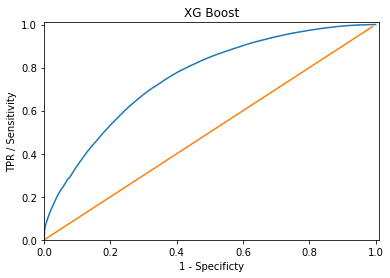

AUC= 0.7553772848455633


In [184]:
y_pred_proba = XB_cls.predict_proba(X_test)
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_pred_proba[:,1], pos_label = 1)
df_roc_logreg = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('XG Boost')
plt.plot(df_roc_logreg['fpr'],df_roc_logreg['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))

plt.show()
print('AUC=', auc(fpr_log, tpr_log))

In [185]:
print(classification_report(y_test, XB_cls.predict(X_test)))

              precision    recall  f1-score   support

           0       0.48      0.81      0.60    282512
           1       0.83      0.52      0.64    516813

    accuracy                           0.62    799325
   macro avg       0.66      0.66      0.62    799325
weighted avg       0.71      0.62      0.63    799325



Observamos que el modelo proporcionó valores bien distintos a lo que teníamos antes, principalmente por el hecho que el dataset está ahora desbalanceado. 

### Random Forest


In [194]:
# Random Forest con los mejores parámetros
rf = RandomForestClassifier(n_estimators=200,n_jobs=-1,max_depth=9)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=9, n_estimators=200, n_jobs=-1)

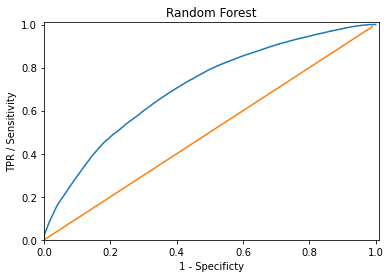

AUC= 0.7103625429114392


In [195]:
y_pred_proba = rf.predict_proba(X_test)
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_pred_proba[:,1], pos_label = 1)
df_roc_logreg = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('Random Forest')
plt.plot(df_roc_logreg['fpr'],df_roc_logreg['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))

plt.show()
print('AUC=', auc(fpr_log, tpr_log))

In [196]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.49      0.69      0.57    282512
           1       0.78      0.61      0.69    516813

    accuracy                           0.64    799325
   macro avg       0.64      0.65      0.63    799325
weighted avg       0.68      0.64      0.65    799325



Finalmente obtenemos los resultados mostrados arriba. Vemos que _Random Tree_ pero no alcanza al rendimiento de XG Boost.

Cabe destacar que por curiosidad probamos también modelos de redes neuronales (en concreto MLPClassifier de la librería sklearn.neural_network) para saber si quizás podríamos ganar algunos puntos en la performances de los modelos, pero los resultados fueron siempre inferiores a los obtenidos con los modelos de random forest y XGBoost. Por este motivo optamos por no incluir el análisis de los mismos en este informe ya que tampoco forma parte del scope del curso.

### Hiperparametrización XGboost

In [211]:
def objective(trial):
    
    booster = trial.suggest_categorical("booster", ["gbtree", 
                                            "dart",
                                           ])
    reg_lambda = trial.suggest_float("lambda", 1e-8, 1.0, log=True)
    alpha = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    subsample =  trial.suggest_float("subsample", 0.2, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 1.0)
    max_depth = trial.suggest_int("max_depth", 4, 12, step=2)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    eta = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    gamma = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    grow_policy = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])


#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
#         param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
#         param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
#         param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    xgb = XGBClassifier(boster = booster,
                       reg_lambda = reg_lambda,
                       alpha = alpha,
                       subsample = subsample,
                       colsample_bytree = colsample_bytree,
                       max_depth = max_depth,
                       min_child_weight = min_child_weight,
                       eta = eta,
                       gamma = gamma,
                       grow_policy = grow_policy,
                       use_label_encoder=False)
    xgb.fit(X_train_, y_train_)

    y_pred = xgb.predict_proba(X_valid)
    fpr_log,tpr_log,thr_log = roc_curve(y_valid, y_pred[:,1], pos_label = 1)

    return auc(fpr_log, tpr_log)


In [98]:
#if __name__ == "__main__":
#    study = optuna.create_study(direction="maximize")
#    study.enqueue_trial({'boster':"gbtree",
#                         'reg_lambda':1,
#                         "alpha":0,
#                         "subsample":1,
#                         "colsample_bytree":1,
#                         "max_depth":6,
#                         "min_child_weight":1,
#                         "eta":0.3,
#                         "gamma":0,
#                         "grow_policy":"depthwise"
#                        })
#    study.optimize(objective, n_trials=54, timeout=6000,
#                   n_jobs = -1
#                  )
#
#    print("Number of finished trials: ", len(study.trials))
#    print("Best trial:")
#    trial = study.best_trial

#    print("  Value: {}".format(trial.value))
#    print("  Params: ")
#    for key, value in trial.params.items():
#        print("    {}: {}".format(key, value))

In [213]:
study.best_trial.params

{'booster': 'gbtree',
 'lambda': 0.010343969414485564,
 'alpha': 0.011257200412481148,
 'subsample': 0.972242063333711,
 'colsample_bytree': 0.42468674880393165,
 'max_depth': 10,
 'min_child_weight': 8,
 'eta': 0.18098818005430026,
 'gamma': 0.01284468421155994,
 'grow_policy': 'lossguide'}

In [63]:
XB_cls = XGBClassifier( booster= "gbtree",
                        reg_lambda= 0.010343969414485564,
                        alpha= 0.011257200412481148,
                        subsample= 0.972242063333711,
                        colsample_bytree= 0.42468674880393165,
                        max_depth= 10,
                        min_child_weight= 8,
                        eta= 0.18098818005430026,
                        gamma= 0.01284468421155994,
                        grow_policy= "lossguide",
                        use_label_encoder=False,
                        eval_metric='logloss'
                      )

XB_cls.fit(X_train,y_train)

XGBClassifier(alpha=0.011257200412481148, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.42468674880393165, eta=0.18098818005430026,
              eval_metric='logloss', gamma=0.01284468421155994, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.180988178,
              max_delta_step=0, max_depth=10, min_child_weight=8, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0112572005,
              reg_lambda=0.010343969414485564, scale_pos_weight=1,
              subsample=0.972242063333711, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

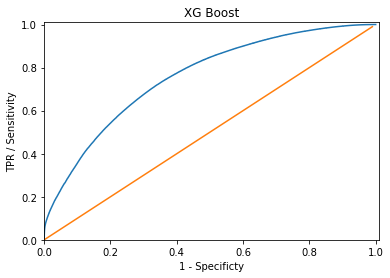

AUC= 0.7569427668966431


In [215]:
y_pred_proba = XB_cls.predict_proba(X_test)
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_pred_proba[:,1], pos_label = 1)
df_roc_logreg = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('XG Boost')
plt.plot(df_roc_logreg['fpr'],df_roc_logreg['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))

plt.show()
print('AUC=', auc(fpr_log, tpr_log))

In [64]:
print(classification_report(y_test, XB_cls.predict(X_test)))

              precision    recall  f1-score   support

           0       0.48      0.83      0.60    282512
           1       0.84      0.50      0.63    516813

    accuracy                           0.62    799325
   macro avg       0.66      0.66      0.62    799325
weighted avg       0.71      0.62      0.62    799325



In [68]:
print(classification_report(y_test, XB_cls.predict_proba(X_test)[:,1]>.215))

              precision    recall  f1-score   support

           0       0.68      0.46      0.55    282512
           1       0.75      0.88      0.81    516813

    accuracy                           0.73    799325
   macro avg       0.71      0.67      0.68    799325
weighted avg       0.72      0.73      0.72    799325



Manipulando el umbral, vamos que podemos recuperar la precisión de 88% en el _recall_ de casos positivos, mientras el _recall_ de los casos negativos todavía es bajo, 46%, pero 3% mejor que lo que teníamos antes. Por lo tanto, vemos una pequeña mejora agregando las informaciones de altitud y temperatura.

Miremos la importáncia de las features.

In [228]:
shap_X_test = pd.get_dummies(pd.DataFrame(X_test.todense()), drop_first = True)

In [229]:
shap_X_test.shape

(799325, 30)

In [237]:
for i in range(5,30):
          shap_X_test[i] =  shap_X_test[i].astype("category")

In [241]:
features_names =['T2M_MIN','T2M_MAX','PRECTOTCORR','ALT','Densidad_Mun','FEBRE_1.0','MIALGIA_1.0','CEFALEIA_1.0',
                 'EXANTEMA_1.0','VOMITO_1.0','NAUSEA_1.0','DOR_COSTAS_1.0','CONJUNTVIT_1.0','ARTRITE_1.0',
                 'ARTRALGIA_1.0','PETEQUIA_N_1.0','LEUCOPENIA_1.0','LACO_1.0','DOR_RETRO_1.0','MES_NOT_agosto',
                 'MES_NOT_diciembre','MES_NOT_enero','MES_NOT_febrero','MES_NOT_julio','MES_NOT_junio',
                 'MES_NOT_marzo','MES_NOT_mayo','MES_NOT_noviembre','MES_NOT_octubre','MES_NOT_septiembre']

In [242]:
shap_X_test.columns = features_names

In [243]:
import shap
pred = XB_cls.predict_proba(X_test)[:,1]>.5
explainer = shap.TreeExplainer(XB_cls)
shap_values = explainer.shap_values(X = X_test, y = y_test.astype("category"))
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


6.6638393

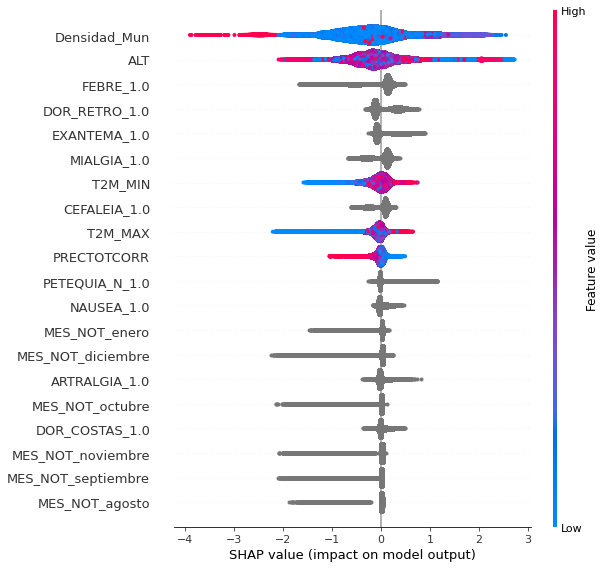

In [244]:
shap.summary_plot(shap_values, shap_X_test, features_names)

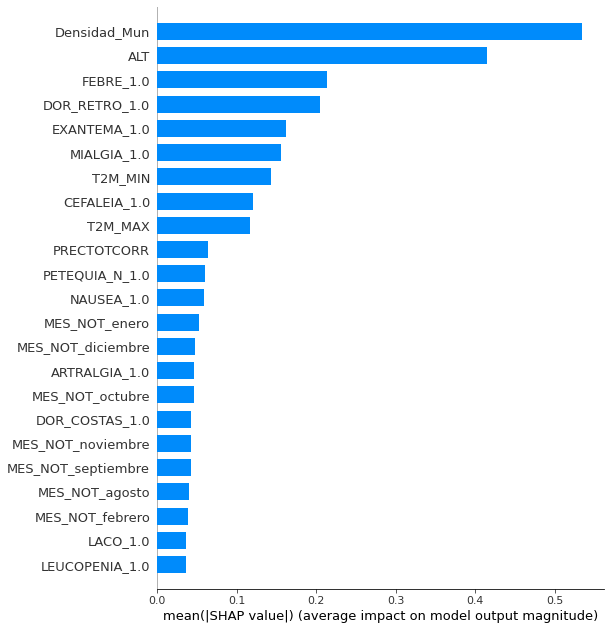

In [245]:
shap.summary_plot(shap_values, features=X_test, plot_type="bar", feature_names = features_names, max_display=X.shape[1])

Como se puede apreciar, las variables de densidad poblacional, altura y los síntomas más comunes son las que mas aportan a nuestro modelo.

En el caso de la variable altura, en una primera instancia pensamos que quizás la especie de mosquito asociada al Dengue (Aedes aegypti) no habitaría en regiones altas. Pero realizando un poco de investigación pudimos comprobar que esta especie habita inlcusive hasta los 2200 msnm. Esta altura es considerablemente superior a la media de los monucipios observados.

Fuentes:

https://www.scielo.sa.cr/scielo.php?script=sci_arttext&pid=S0034-77442010000100017 https://www.minsalud.gov.co/salud/publica/PET/Paginas/dengue.aspx#:~:text=Los%20mosquitos%20del%20dengue%20se,y%20que%20puede%20almacenar%20agua.

Siguen teniendo relevancia relativa los síntomas más comunes del Dengue: Fiebre, dolor retro ocular, sarpullido (exantema) y dolor de cabeza. Asimismo las temperaturas mínimas y máximos podrían justificar su aporte porque explican la cantidad de mosquitos que puede haber (a mayor temperatura, mayor reproducción de mosquitos). Idem las precipitaciones (prectotcorr) pero en menor medida.
Síntomas poco relacionados con el dengue como conjutivitis o inflamación de articulaciones (más relacionada con chikungunya) tienen un aporte bastante inferior al resto.

## Exportando el modelo final

Vamos usar la biblioteca pickle para exportar el modelo final.

In [69]:
with open('model.pkl','wb') as files:
    pickle.dump(XB_cls,files)

# Conlusión final

Al iniciar este trabajo, lo hicimos con la motivación de encontrar un modelo que sea de ayuda al determinar si una persona que llega a una institución médica con la sospecha de haber contraído el virus del Dengue o Chikungunya debería continuar con estudios más específicos o si dicho diagnóstico podría ser descartado inmediatamente. Como comentábamos anteriormente esto podría ayudar a reducir en gran medida el número de testeos realizados y por lo tanto ayudar a prevenir que los centros de testeo se sobrecarguen innecesariamente.

En un primer análisis pudimos observar que el objetivo no iba a ser fácil de cumplir. En primera instancia nos encontramos con la dificultad de que ambas enfermedades tienen muchos síntomas en común (además de que son síntomas comunes con otras enfermedades también), esto hace que sea difícil predecir si la enfermedad se trata potencialmente de Dengue o Chikungunya. Luego, nos encontramos con otra dificultad, en este caso una dificultad que parece ser una constante en cada trabajo que hemos realizado a lo largo del curso, y es la falta de datos o "datos de calidad". En este caso, a priori, parecía que disponíamos de suficientes datos para ambas enfermedades, pero al analizarlos con detenimiento notamos que para el caso de Chikungunya, los mismos no eran útiles por tener demasiados valores incompletos. Esto nos llevó a tener que desestimar parte de nuestros objetivos iniciales y enfocarnos solo en una de las enfermedades, el Dengue.

Una vez determinados los nuevos objetivos de nuestro trabajo, avanzamos y llegamos a resultados "razonables" que posiblemente serían de ayuda para descartar algunos casos en una primera instancia, pero no consideramos que esto fuera suficiente. Realmente esperábamos obtener mejores predicciones. Fue este el motivo que nos impulsó a buscar datos "afuera", datos que no pertenecían al dataset original pero que sospechábamos que podrían agregar señal a nuestros modelos. Finalmente, y luego de múltiples pruebas y errores logramos dar con datos que nos ayudaron a alcanzar métricas más cercanas a las que buscábamos en un principio. Somos conscientes de que esto fue a costa de resignar simplicidad en la estructura de los datos y requerir de modelos más complejos.

Nos enfocamos en mejorar la métrica _recall_, dado que la premisa es que ningún caso positivo pase desapercibido. Esto es con el fin de prevenir que una persona se descuide de contraer por segunda vez el virus, lo que puede derivar en una enfermedad más grave. El modelo final alcanzado tiene una especificidad de ~90 % para los casos positivos. Si bien en este porcentaje está incluido un número de falsos positivos que serán testeados innecesariamente, generando un costo económico al Estado, hay baja probabilidad de que una persona infectada no sea diagnosticada, lo que significará un gran impacto en la medicina preventiva de Brasil.